# Course Project - Solar PV in Germany

Part I - Machine Learning

*Name*: Andreas Eckmann

*E-Mail*: eckmanna@ethz.ch

## Set Up

In [600]:
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None # Display all columns of a dataframe
pd.options.display.max_rows = 700
from pprint import pprint

import time
import datetime
import os
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import sklearn

In [601]:
# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

## Reading Data

In [602]:
# load the csv data from my online repository
data = pd.read_excel('https://raw.githubusercontent.com/eckmanna/big_data_policy_2020/master/course_project/data/df_pv_data_germany.xlsx').iloc[:, :] #avoiding "unnamed"-row
print(data.shape,
      data.head())

(464, 25)    Year         Bundesland  Installed_Cap  Installed_Cap_below_30  \
0  1992  Baden-Württemberg        124.661                 124.661   
1  1992             Bayern        157.574                 157.574   
2  1992             Berlin        127.110                 127.110   
3  1992        Brandenburg         37.880                  37.880   
4  1992             Bremen         57.060                  57.060   

   Cum_Installed_cap  Cum_Installed_Cap_below_30  module_cost  feed-in  \
0            124.661                     124.661          8.0   8.4303   
1            157.574                     157.574          8.0   8.4303   
2            127.110                     127.110          8.0   8.4303   
3             37.880                      37.880          8.0   8.4303   
4             57.060                      57.060          8.0   8.4303   

   population      area   log_area       GDP  Installed_Cap_pa  \
0  10148708.0  35673.71  10.482169  255866.0          0.003494  

In [603]:
data.dtypes

Year                               int64
Bundesland                        object
Installed_Cap                    float64
Installed_Cap_below_30           float64
Cum_Installed_cap                float64
Cum_Installed_Cap_below_30       float64
module_cost                      float64
feed-in                          float64
population                       float64
area                             float64
log_area                         float64
GDP                              float64
Installed_Cap_pa                 float64
Cum_Installed_Cap_pa             float64
Installed_Cap_below_30_pc        float64
Cum_Installed_Cap_below_30_pc    float64
Installed_Cap_pc                 float64
Cum_Installed_Cap_pc             float64
pop_density                      float64
GDP_pc                           float64
solar_irradiance                   int64
sun_hours                          int64
share_green_party                float64
share_RE                         float64
share_PV        

## Data plotting

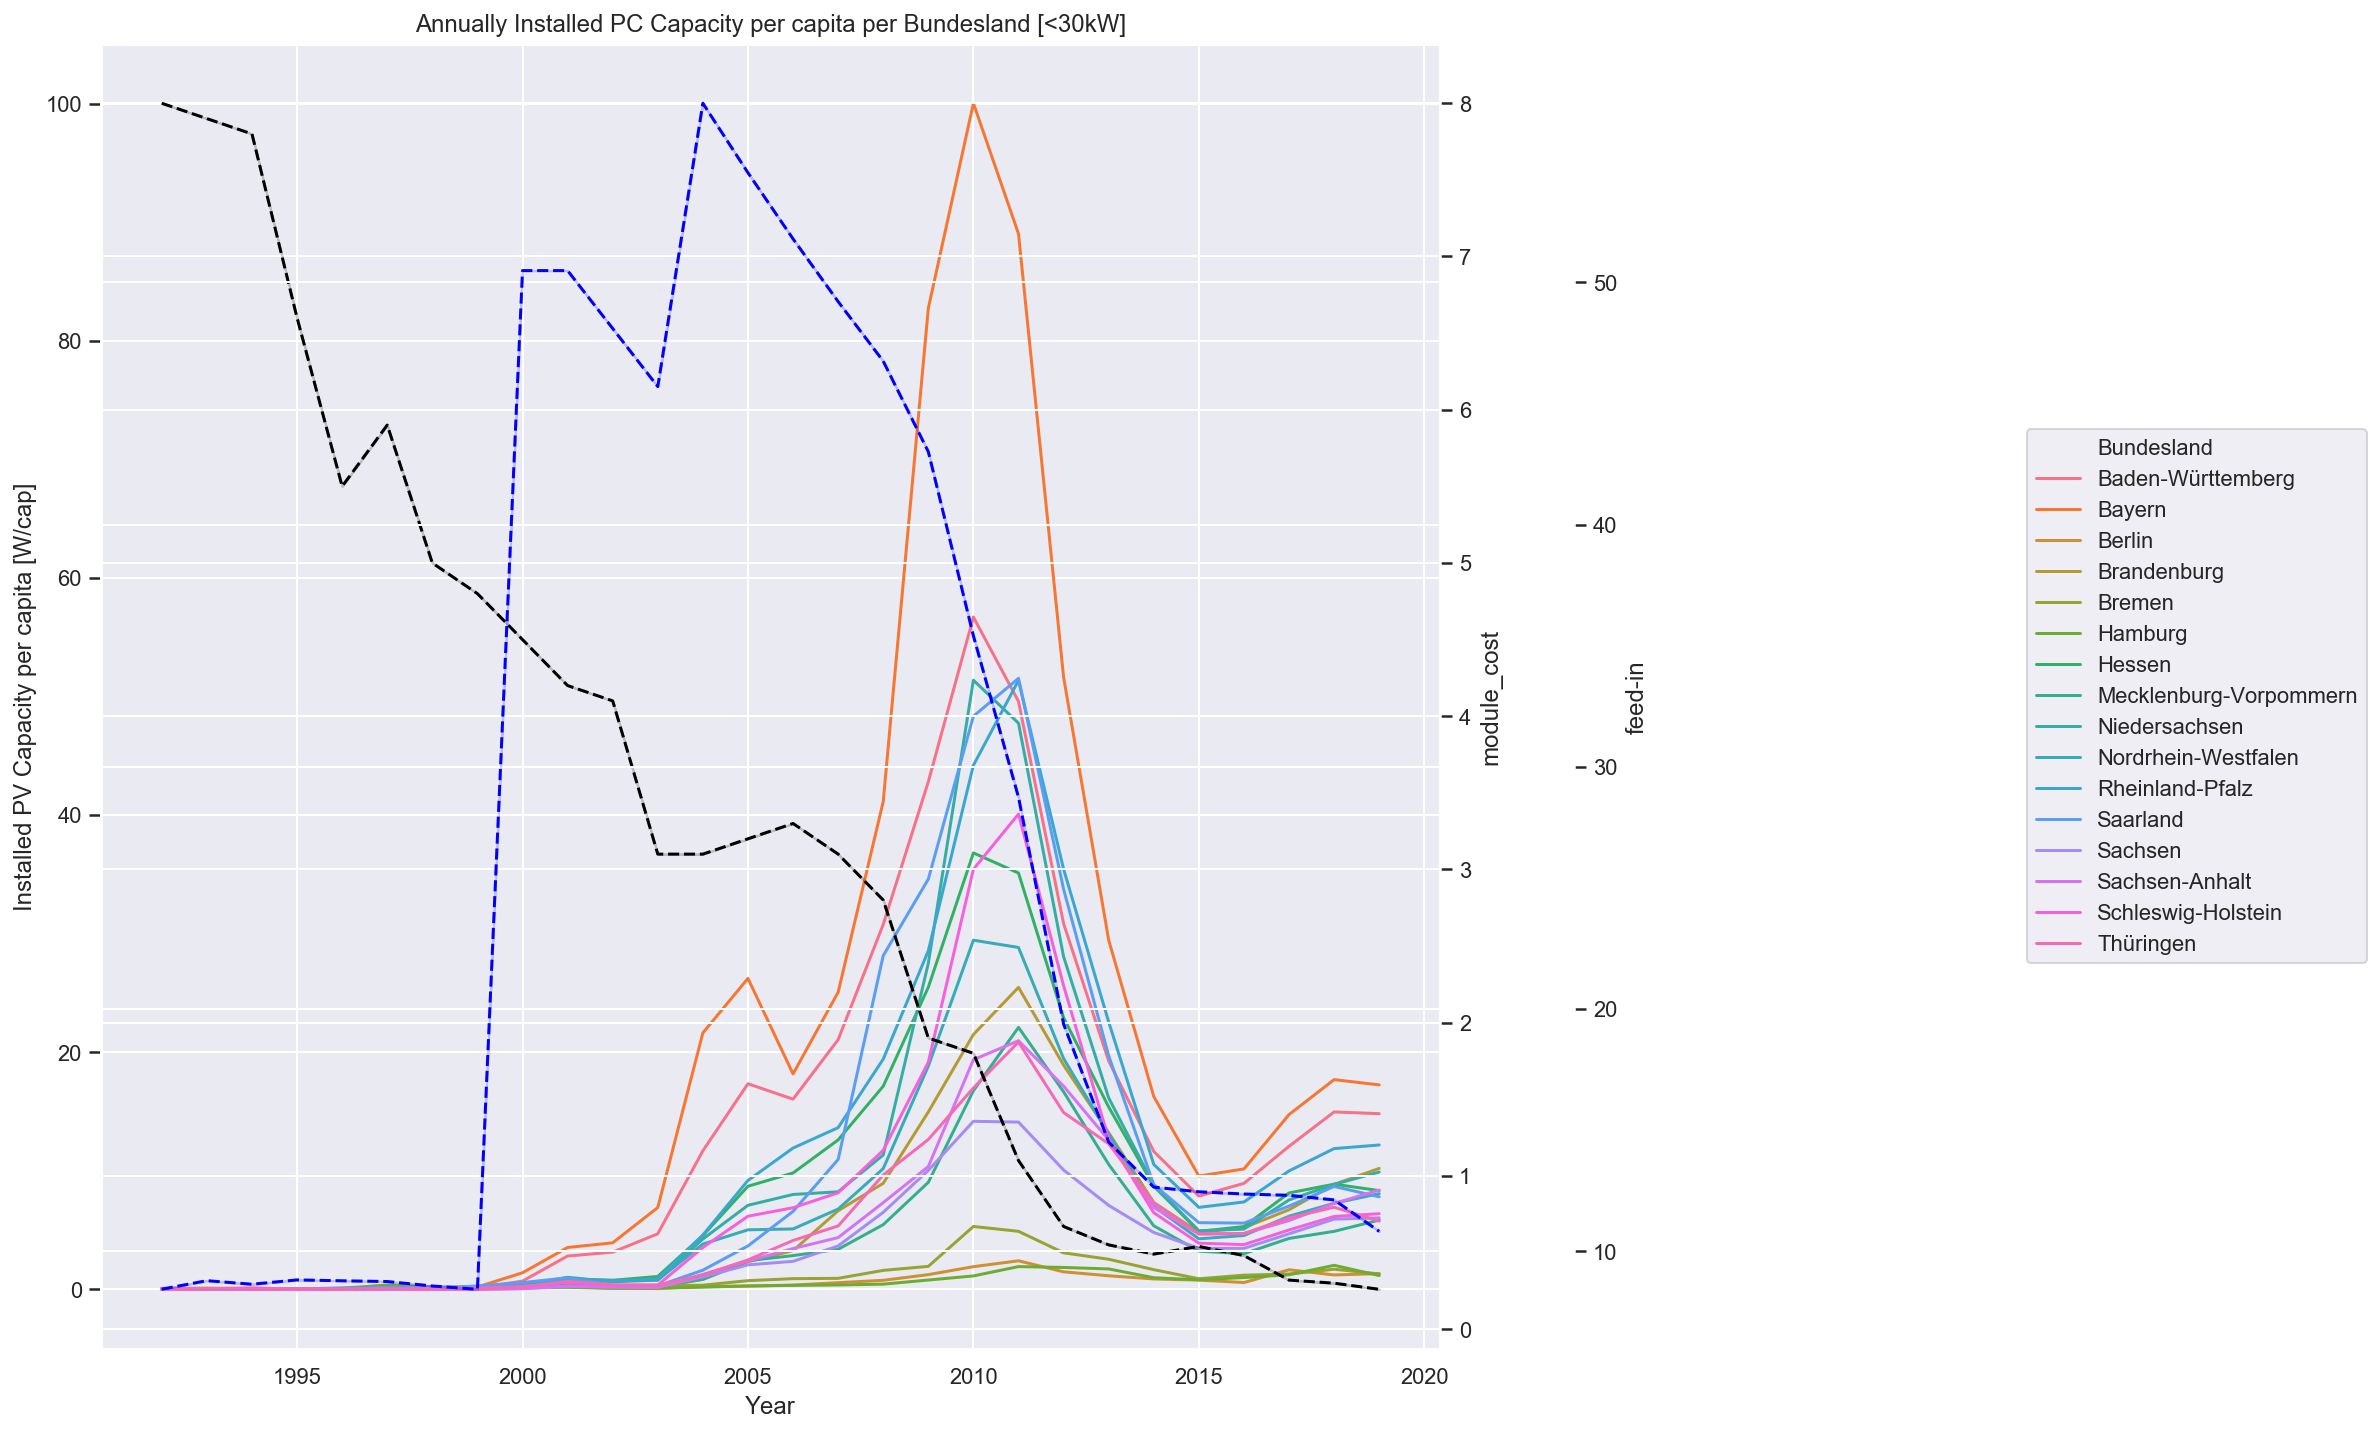

In [816]:
p1 = sns.lineplot(x = "Year", y="Installed_Cap_below_30_pc", hue="Bundesland", data = data)

#plot module-costs
ax2 = p1.twinx()
sns.lineplot(x = "Year", y="module_cost", color="black", dashes=True, data = data, ax = ax2)
ax2.spines['right'].set_position(('axes', 1.0))
ax2.lines[0].set_linestyle("--")

#plot feed-in
ax3 = p1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
sns.lineplot(x = "Year", y="feed-in", color="blue", data = data, ax = ax3)
ax3.lines[0].set_linestyle("--")

p1.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)
p1.set(xlabel="Year",
       ylabel="Installed PV Capacity per capita [W/cap]",
       title= "Annually Installed PC Capacity per capita per Bundesland [<30kW]")
plt.show()

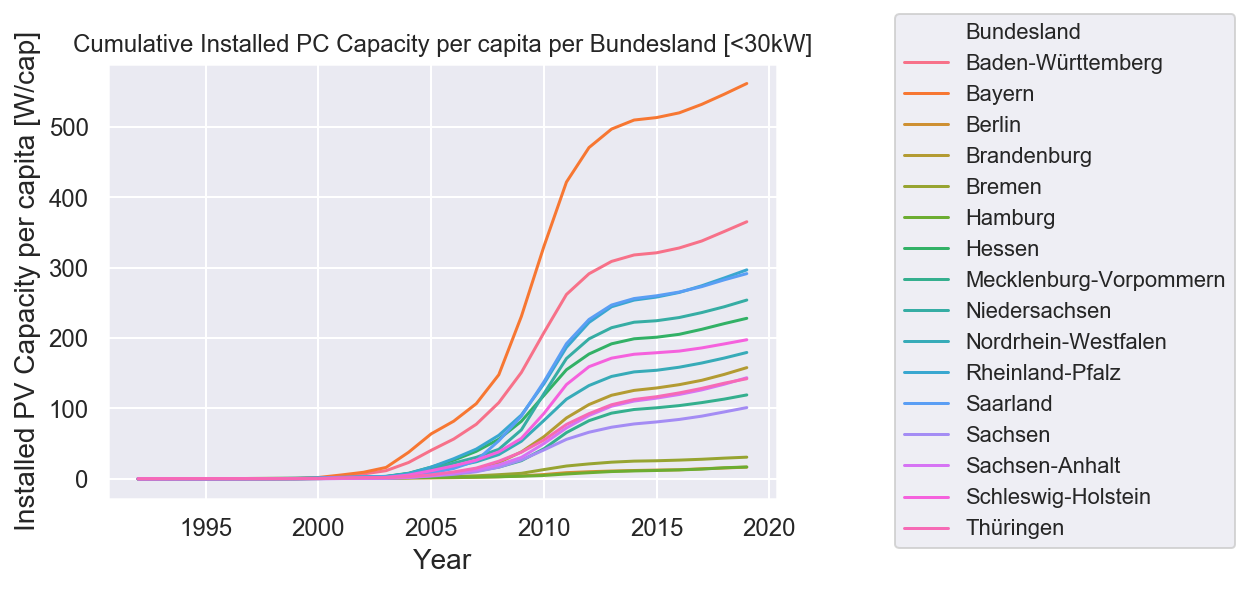

In [605]:
p2 = sns.lineplot(x="Year", y="Cum_Installed_Cap_below_30_pc", hue="Bundesland", data = data)
p2.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)
p2.set(xlabel="Year",
       ylabel="Installed PV Capacity per capita [W/cap]",
       title= "Cumulative Installed PC Capacity per capita per Bundesland [<30kW]")
plt.show()

[Text(0, 0.5, 'GDP per capita [EUR/cap]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'GDP per capita per Bundesland')]

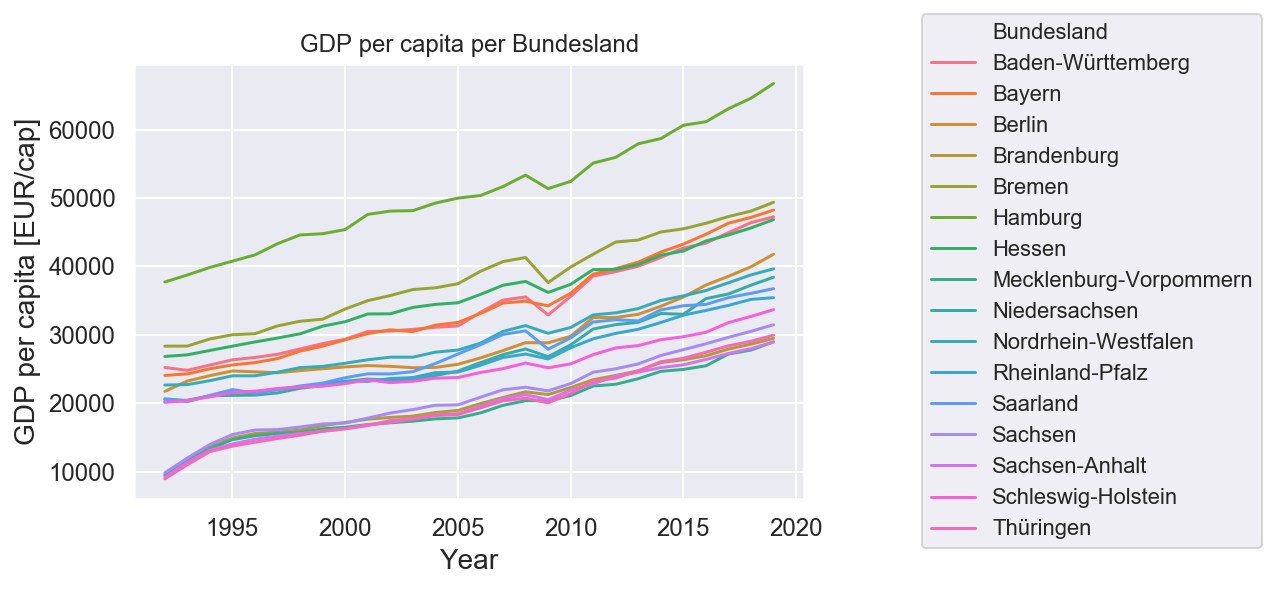

In [606]:
p3 = sns.lineplot(x="Year", y="GDP_pc", hue="Bundesland", data = data)
p3.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)
p3.set(xlabel="Year",
       ylabel="GDP per capita [EUR/cap]",
       title= "GDP per capita per Bundesland")

[Text(0, 0.5, 'Population density [cap/km2]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Population density per Bundesland')]

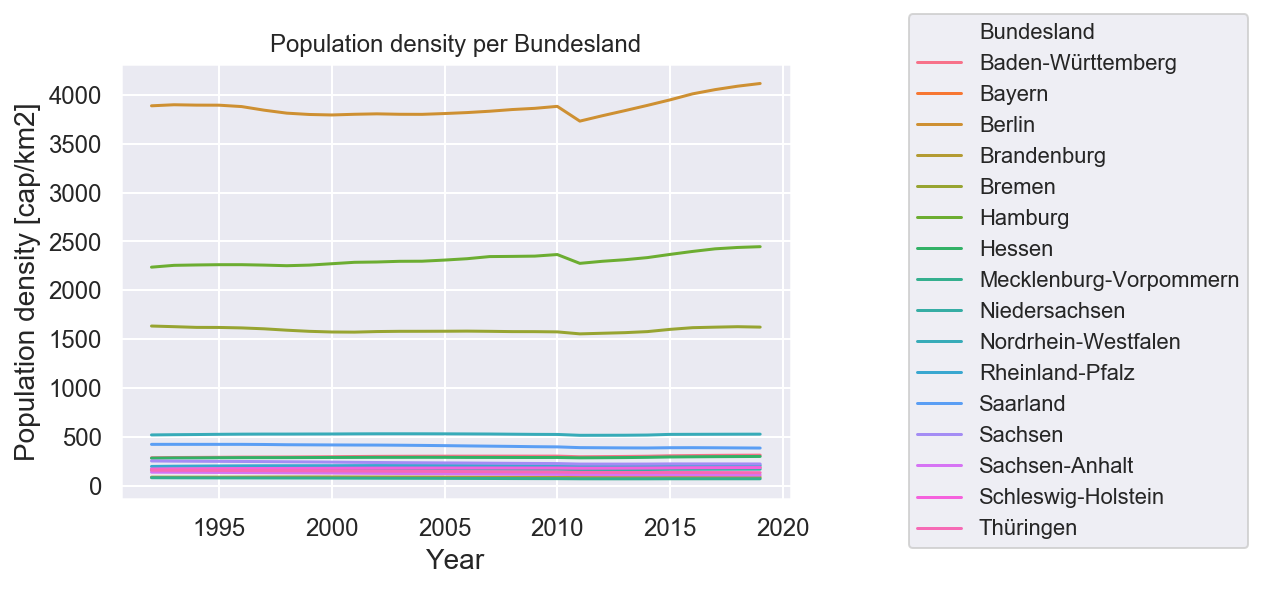

In [607]:
p4 = sns.lineplot(x="Year", y="pop_density", hue="Bundesland", data = data)
p4.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)
p4.set(xlabel="Year",
       ylabel="Population density [cap/km2]",
       title= "Population density per Bundesland")

[Text(0, 0.5, 'Share [-]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Share of green party in the parliament')]

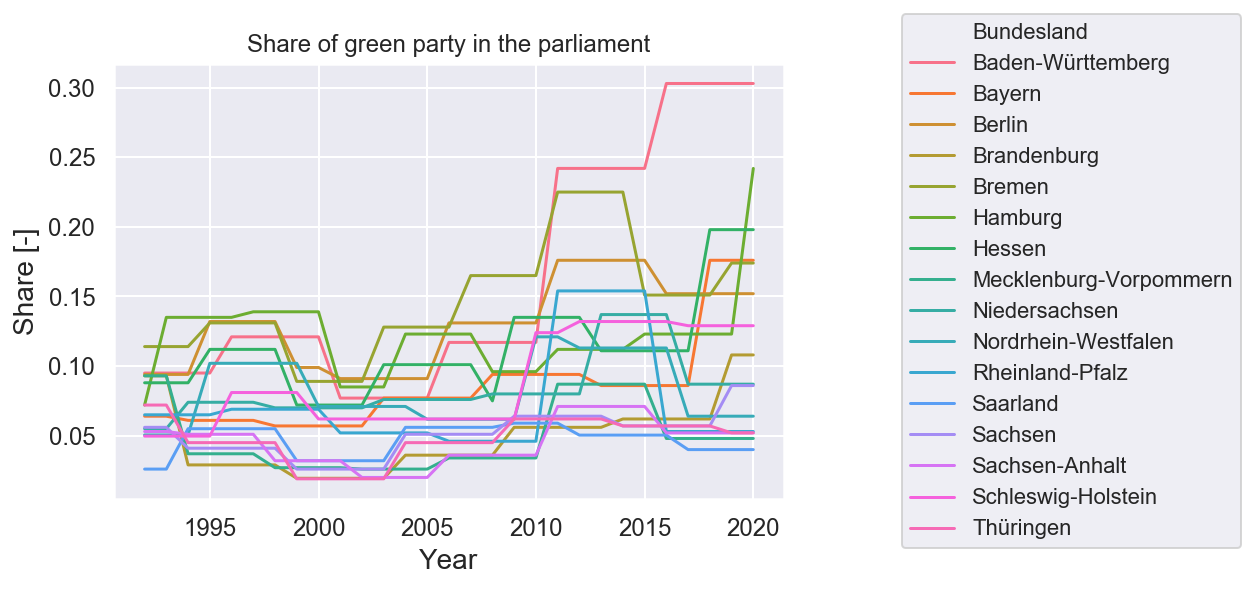

In [608]:
p5 = sns.lineplot(x="Year", y="share_green_party", hue="Bundesland", data = data)
p5.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)
p5.set(xlabel="Year",
       ylabel="Share [-]",
       title= "Share of green party in the parliament")

## Data preparation for ML regressions

In [609]:
# filter to only work with complete data (balanced panel)
df1 = data[(data.Year>=1992) & (data.Year<2020)]
df1.head()

Year         Bundesland  Installed_Cap  Installed_Cap_below_30  \
0  1992  Baden-Württemberg        124.661                 124.661   
1  1992             Bayern        157.574                 157.574   
2  1992             Berlin        127.110                 127.110   
3  1992        Brandenburg         37.880                  37.880   
4  1992             Bremen         57.060                  57.060   

   Cum_Installed_cap  Cum_Installed_Cap_below_30  module_cost  feed-in  \
0            124.661                     124.661          8.0   8.4303   
1            157.574                     157.574          8.0   8.4303   
2            127.110                     127.110          8.0   8.4303   
3             37.880                      37.880          8.0   8.4303   
4             57.060                      57.060          8.0   8.4303   

   population      area   log_area       GDP  Installed_Cap_pa  \
0  10148708.0  35673.71  10.482169  255866.0          0.003494   
1  11770257.0  70542.03  11.163964  283121.0          0.002234   
2   3465748.0    891.12   6.792479   75252.0          0.142641   
3   2542651.0  29654.38  10.297365   24556.0          0.001277   
4    685845.0    419.84   6.039874   19427.0          0.135909   

   Cum_Installed_Cap_pa  Installed_Cap_below_30_pc  \
0              0.003494                   0.012283   
1              0.002234                   0.013387   
2              0.142641                   0.036676   
3              0.001277                   0.014898   
4              0.135909                   0.083197   

   Cum_Installed_Cap_below_30_pc  Installed_Cap_pc  Cum_Installed_Cap_pc  \
0                       0.012283          0.012283              0.012283   
1                       0.013387          0.013387              0.013387   
2                       0.036676          0.036676              0.036676   
3                       0.014898          0.014898              0.014898   
4                       0.083197          0.083197              0.083197   

   pop_density        GDP_pc  solar_irradiance  sun_hours  share_green_party  \
0   284.487035  25211.682118              1100       1755              0.095   
1   166.854526  24053.935271              1180       1805              0.064   
2  3889.204596  21713.061654              1009       1590              0.094   
3    85.742848   9657.636852              1005       1615              0.093   
4  1633.586604  28325.642091               980       1455              0.114   

   share_RE  share_PV  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN

In [610]:
df1.tail()

Year          Bundesland  Installed_Cap  Installed_Cap_below_30  \
443  2019            Saarland      19777.684                7698.804   
444  2019             Sachsen     235403.225               24544.416   
445  2019      Sachsen-Anhalt     331173.524               18374.647   
446  2019  Schleswig-Holstein     114727.161               18513.801   
447  2019           Thüringen     192679.017               12265.767   

     Cum_Installed_cap  Cum_Installed_Cap_below_30  module_cost  feed-in  \
443         787983.029                  287947.655         0.26  10.8175   
444        3144144.199                  412433.670         0.26  10.8175   
445        3959334.167                  315434.272         0.26  10.8175   
446        2782539.566                  574167.107         0.26  10.8175   
447        2384504.505                  303697.871         0.26  10.8175   

     population      area  log_area       GDP  Installed_Cap_pa  \
443    986887.0   2571.10  7.852089   36253.0          7.692304   
444   4071971.0  18449.99  9.822819  128097.0         12.758989   
445   2194782.0  20452.14  9.925843   63545.0         16.192610   
446   2903773.0  15802.27  9.667909   97762.0          7.260170   
447   2133378.0  16202.37  9.692913   63866.0         11.892027   

     Cum_Installed_Cap_pa  Installed_Cap_below_30_pc  \
443            306.477006                   7.801100   
444            170.414412                   6.027650   
445            193.590214                   8.371969   
446            176.084801                   6.375774   
447            147.170106                   5.749458   

     Cum_Installed_Cap_below_30_pc  Installed_Cap_pc  Cum_Installed_Cap_pc  \
443                     291.773683         20.040475            798.453145   
444                     101.286004         57.810634            772.143072   
445                     143.720092        150.891307           1803.976052   
446                     197.731402         39.509687            958.249686   
447                     142.355396         90.316398           1117.713085   

     pop_density        GDP_pc  solar_irradiance  sun_hours  \
443   383.838435  36734.702149              1060       1665   
444   220.703155  31458.229933              1040       1630   
445   107.313073  28952.761595              1020       1555   
446   183.756701  33667.232253               975       1500   
447   131.670737  29936.560703              1000       1500   

     share_green_party  share_RE  share_PV  
443              0.040       NaN       NaN  
444              0.086       NaN       NaN  
445              0.052       NaN       NaN  
446              0.129       NaN       NaN  
447              0.052       NaN       NaN

In [611]:
# extract list of bundeslaender
bundeslaender = df1['Bundesland'].unique()

# extract list of years
years = df1['Year'].unique()

print(bundeslaender)
print(bundeslaender.shape)
print(years)
print(years.shape)

['Baden-Württemberg' 'Bayern' 'Berlin' 'Brandenburg' 'Bremen' 'Hamburg'
 'Hessen' 'Mecklenburg-Vorpommern' 'Niedersachsen' 'Nordrhein-Westfalen'
 'Rheinland-Pfalz' 'Saarland' 'Sachsen' 'Sachsen-Anhalt'
 'Schleswig-Holstein' 'Thüringen']
(16,)
[1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
(28,)


The following independent variables are used for ML prediction:
- Year
- Module costs (national) [2016EUR/Wp]
- Feed-in-Tariff (national) [ct/kWh]
- Population (sub-national) [capita]
- Area (sub-national) [km2]
- GDP per capita (sub-national) [EUR/cap]
- Solar irradiance (sub-national) [kWh/m2]
- Sun hours (sub-national) [hrs/m2]
- Share of the green party in parliament (sub-national) [0,1]

National variables have the same values for all states (Bundesländer).

Sub-national variables describe regional differences and are unique for each state (Bundesland).

Variables not used due to incompleteness:
- Share of Renewable Energy on electricity production (sub-national) [0,1]
- Share of PV on electricity production (sub-national) [0,1]

In [612]:
# X from datafram to array
X_full = df1[['Year','module_cost','feed-in','population','area','GDP_pc','solar_irradiance','sun_hours','share_green_party']].to_numpy()
# use both population and area, rather than population density only
X_full.shape

(448, 9)

In [613]:
# Bundeslaender from dataframe to array
Bundesland_full = df1['Bundesland'].to_numpy()
print(Bundesland_full.shape)

(448,)


The dependent outcome variable Y:
- Installed PV Capacity per capita for installations <30kW (sub-national) [W/cap]

In [614]:
# Y from datafram to array
Y_full = df1['Installed_Cap_below_30_pc'].to_numpy()
Y_full.shape

(448,)

In [615]:
# X from array to dataframe
X_df = pd.DataFrame(X_full, columns=['Year','module_cost','feed-in','population','area','GDP_pc','solar_irradiance','sun_hours','share_green_party'])
# Format year
X_df['Year'] = pd.to_datetime(X_df['Year'], format='%Y').dt.year
X_df.head()

Year  module_cost  feed-in  population      area        GDP_pc  \
0  1992          8.0   8.4303  10148708.0  35673.71  25211.682118   
1  1992          8.0   8.4303  11770257.0  70542.03  24053.935271   
2  1992          8.0   8.4303   3465748.0    891.12  21713.061654   
3  1992          8.0   8.4303   2542651.0  29654.38   9657.636852   
4  1992          8.0   8.4303    685845.0    419.84  28325.642091   

   solar_irradiance  sun_hours  share_green_party  
0            1100.0     1755.0              0.095  
1            1180.0     1805.0              0.064  
2            1009.0     1590.0              0.094  
3            1005.0     1615.0              0.093  
4             980.0     1455.0              0.114

In [616]:
#check for missing values
print("Missing X values:", X_df.isnull().sum())
print("Missing Y values:", df1['Installed_Cap_below_30_pc'].isnull().sum())

Missing X values: Year                 0
module_cost          0
feed-in              0
population           0
area                 0
GDP_pc               0
solar_irradiance     0
sun_hours            0
share_green_party    0
dtype: int64
Missing Y values: 0


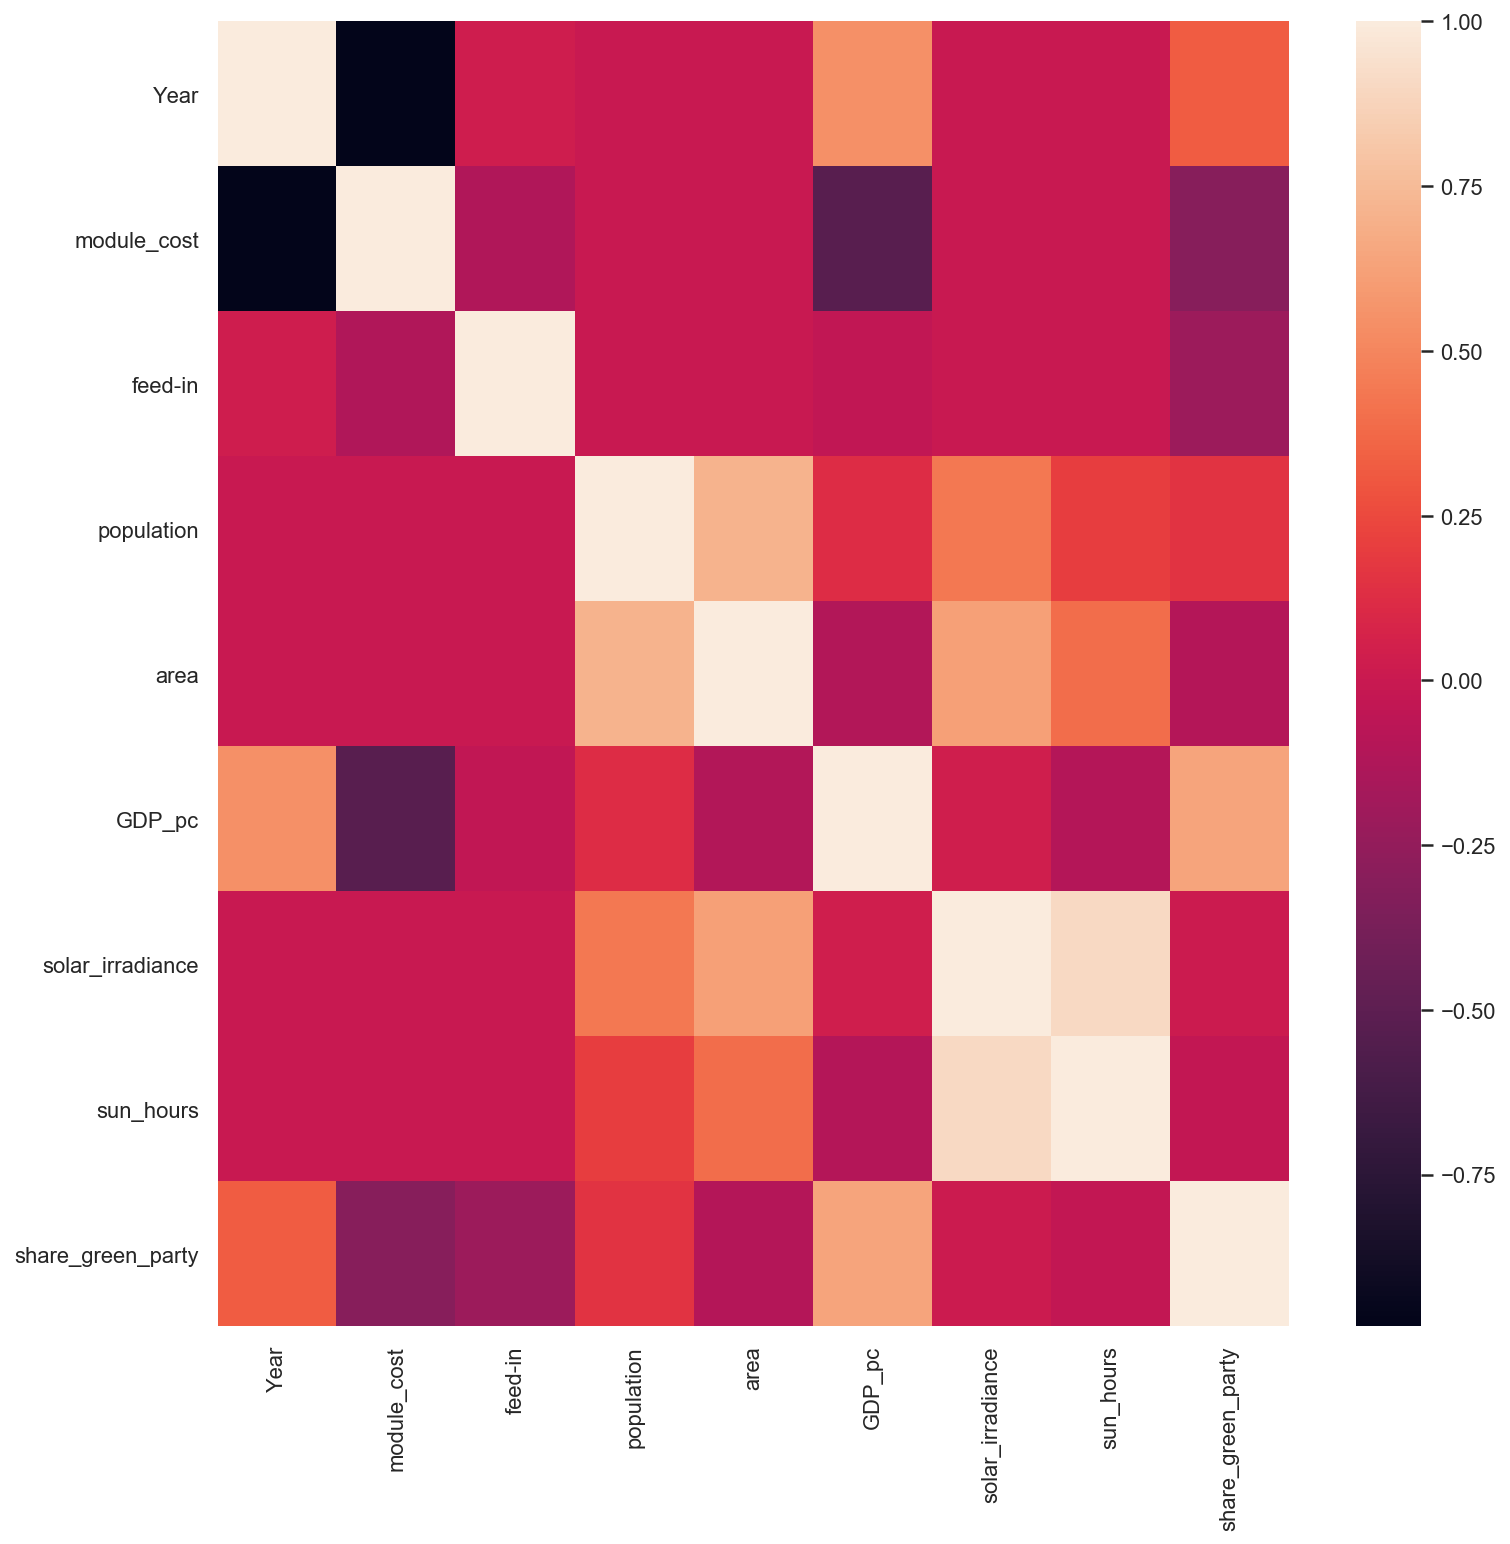

In [617]:
sns.set(rc={'figure.figsize':(12,12)})
correlation_matrix = X_df.corr().round(2)
sns.heatmap(correlation_matrix) #annot=True
plt.show()

## ML CODE

In [618]:
print("X_full", X_full.shape)
print("Y_full", Y_full.shape)

X_full (448, 9)
Y_full (448,)


In [619]:
X_df.head()

Year  module_cost  feed-in  population      area        GDP_pc  \
0  1992          8.0   8.4303  10148708.0  35673.71  25211.682118   
1  1992          8.0   8.4303  11770257.0  70542.03  24053.935271   
2  1992          8.0   8.4303   3465748.0    891.12  21713.061654   
3  1992          8.0   8.4303   2542651.0  29654.38   9657.636852   
4  1992          8.0   8.4303    685845.0    419.84  28325.642091   

   solar_irradiance  sun_hours  share_green_party  
0            1100.0     1755.0              0.095  
1            1180.0     1805.0              0.064  
2            1009.0     1590.0              0.094  
3            1005.0     1615.0              0.093  
4             980.0     1455.0              0.114

In [716]:
## RE-LOADING THE DATA
# X from datafram to array

X_full = df1[['Year','module_cost','feed-in','population','area','GDP_pc','solar_irradiance','sun_hours','share_green_party']].to_numpy()
#X_full = df1[['Year','module_cost','feed-in','solar_irradiance','sun_hours','share_green_party']].to_numpy()
# use both population and area, rather than population density only
print(X_full.shape)


# Y from datafram to array
Y_full = df1['Installed_Cap_below_30_pc'].to_numpy()
print(Y_full.shape)

# Bundeslaender from dataframe to array
Bundesland_full = df1['Bundesland'].to_numpy()
print(Bundesland_full.shape)

# X from array to dataframe
X_df = pd.DataFrame(X_full, columns=['Year','module_cost','feed-in','population','area','GDP_pc','solar_irradiance','sun_hours','share_green_party'])
#X_df = pd.DataFrame(X_full, columns=['Year','module_cost','feed-in','solar_irradiance','sun_hours','share_green_party'])
# Format year
X_df['Year'] = pd.to_datetime(X_df['Year'], format='%Y').dt.year
X_df.head()

(448, 9)
(448,)
(448,)


Year  module_cost  feed-in  population      area        GDP_pc  \
0  1992          8.0   8.4303  10148708.0  35673.71  25211.682118   
1  1992          8.0   8.4303  11770257.0  70542.03  24053.935271   
2  1992          8.0   8.4303   3465748.0    891.12  21713.061654   
3  1992          8.0   8.4303   2542651.0  29654.38   9657.636852   
4  1992          8.0   8.4303    685845.0    419.84  28325.642091   

   solar_irradiance  sun_hours  share_green_party  
0            1100.0     1755.0              0.095  
1            1180.0     1805.0              0.064  
2            1009.0     1590.0              0.094  
3            1005.0     1615.0              0.093  
4             980.0     1455.0              0.114

### Remove Data for better Model fit

In [677]:
mask_year = X_full[:,0]<2000 #drop data before 2000

In [679]:
# optional: apply different masks
mask_year = np.logical_or.reduce((X_full[:,0]<2000, #drop data before 2000
                                  X_full[:,0]==2009,
                                  X_full[:,0]==2010,
                                  X_full[:,0]==2011))

In [717]:
# optional: apply different masks
mask_year = np.logical_or.reduce((X_full[:,0]<2000, #drop data before 2000
                                  X_full[:,0]>2015))

In [718]:
Y_full=Y_full[mask_year==False]
X_full=X_full[mask_year==False]
X_df=X_df[mask_year==False]
Bundesland_full=Bundesland_full[mask_year==False]

print(X_full.shape)
print(Y_full.shape)
print(Bundesland_full.shape)

(256, 9)
(256,)
(256,)


### Data Split
data from years 1992 - 2019 (28 years)

train 75% or 21 years: from 1992 - 2012

test 25% or 7 years: from 2013 - 2019

In [719]:
# splitting the data
split = 2012
mask = X_full[:,0] >= split # TRUE for test data from split-year on
X_train = X_full[mask == False]
Y_train = Y_full[mask == False]

X_test = X_full[mask == True]
Y_test = Y_full[mask == True]

Bundesland_train = Bundesland_full[mask==False]
Bundesland_test = Bundesland_full[mask==True]

print("mask", mask.shape)
print("train data", X_train.shape, Y_train.shape)
print("test data", X_test.shape,  Y_test.shape)
print("bundeslaender in train data", Bundesland_train.shape)
print("bundeslaender in test data", Bundesland_test.shape)

mask (256,)
train data (192, 9) (192,)
test data (64, 9) (64,)
bundeslaender in train data (192,)
bundeslaender in test data (64,)


In [720]:
from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=2)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, Y_train)

Y_train_pred = lin_reg.predict(X_train_poly)
Y_test_pred = lin_reg.predict(X_test_poly)

train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(Y_test,Y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(Y_train, Y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(Y_test, Y_test_pred), 2))

train RMS: 6.431847849647939
test RMS: 54.23301714296216
train R2: 0.85
test R2: -28.12


For plotting the results:

In [721]:
# create a new dataframe for plotting the results
Y = pd.DataFrame(df1, columns=['Year','Bundesland','Installed_Cap_below_30_pc'])

# create a new variable "Data" to classify the type of data
Y['Data'] = "$Y_i$ Installed Capacity"
Y = Y.rename(columns = {'Installed_Cap_below_30_pc':'Y'})
Y.head()

Year         Bundesland         Y                      Data
0  1992  Baden-Württemberg  0.012283  $Y_i$ Installed Capacity
1  1992             Bayern  0.013387  $Y_i$ Installed Capacity
2  1992             Berlin  0.036676  $Y_i$ Installed Capacity
3  1992        Brandenburg  0.014898  $Y_i$ Installed Capacity
4  1992             Bremen  0.083197  $Y_i$ Installed Capacity

In [722]:
# function for plotting fti quality
def plot_fit_quality(values_test, predicted):
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    x = np.arange(len(predicted))
    plt.scatter(x, predicted - values_test, color='steelblue', marker='o') 

    plt.plot([0, len(predicted)], [0, 0], "k:")
    
    max_diff = np.max(np.abs(predicted - values_test))
    plt.ylim([-max_diff, max_diff])
    
    plt.ylabel("error")
    plt.xlabel("sample id")

    plt.subplot(1, 2, 2)

    plt.scatter(x, (predicted - values_test) / values_test, color='steelblue', marker='o') 
    plt.plot([0, len(predicted)], [0, 0], "k:")
    plt.ylim([-.5, .5])
      
    plt.ylabel("relative error")
    plt.xlabel("sample id")

### Linear Regression

In [723]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
features = list(X_df.columns)

from sklearn.metrics import mean_squared_error
Y_train_pred = lin_reg.predict(X_train)
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(train_mse)

Y_test_pred = lin_reg.predict(X_test)        
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(test_mse)

from sklearn.metrics import r2_score
r2 = round(r2_score(Y_test, Y_test_pred), 2)

from sklearn.metrics import explained_variance_score
exp_var = round(explained_variance_score(Y_test,Y_test_pred),2)

print('The coefficients of the features from the linear model:')
print(dict(zip(features, [round(x, 2) for x in lin_reg.coef_])))
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train, Y_train), 2)))
print("Train RMS: %s" % train_rmse) # = np.sqrt(np.mean((predicted - expected) ** 2))
print("Test RMS: %s" % test_rmse)
print("R2: %s" % r2)
print("Explained variance: %s" % exp_var)

The coefficients of the features from the linear model:
{'Year': 1.51, 'module_cost': -1.85, 'feed-in': -0.57, 'population': -0.0, 'area': 0.0, 'GDP_pc': 0.0, 'solar_irradiance': 0.11, 'sun_hours': -0.0, 'share_green_party': -3.73}
R-squared for training dataset:0.66
Train RMS: 9.607000383410982
Test RMS: 36.3735156715006
R2: -12.1
Explained variance: -0.31


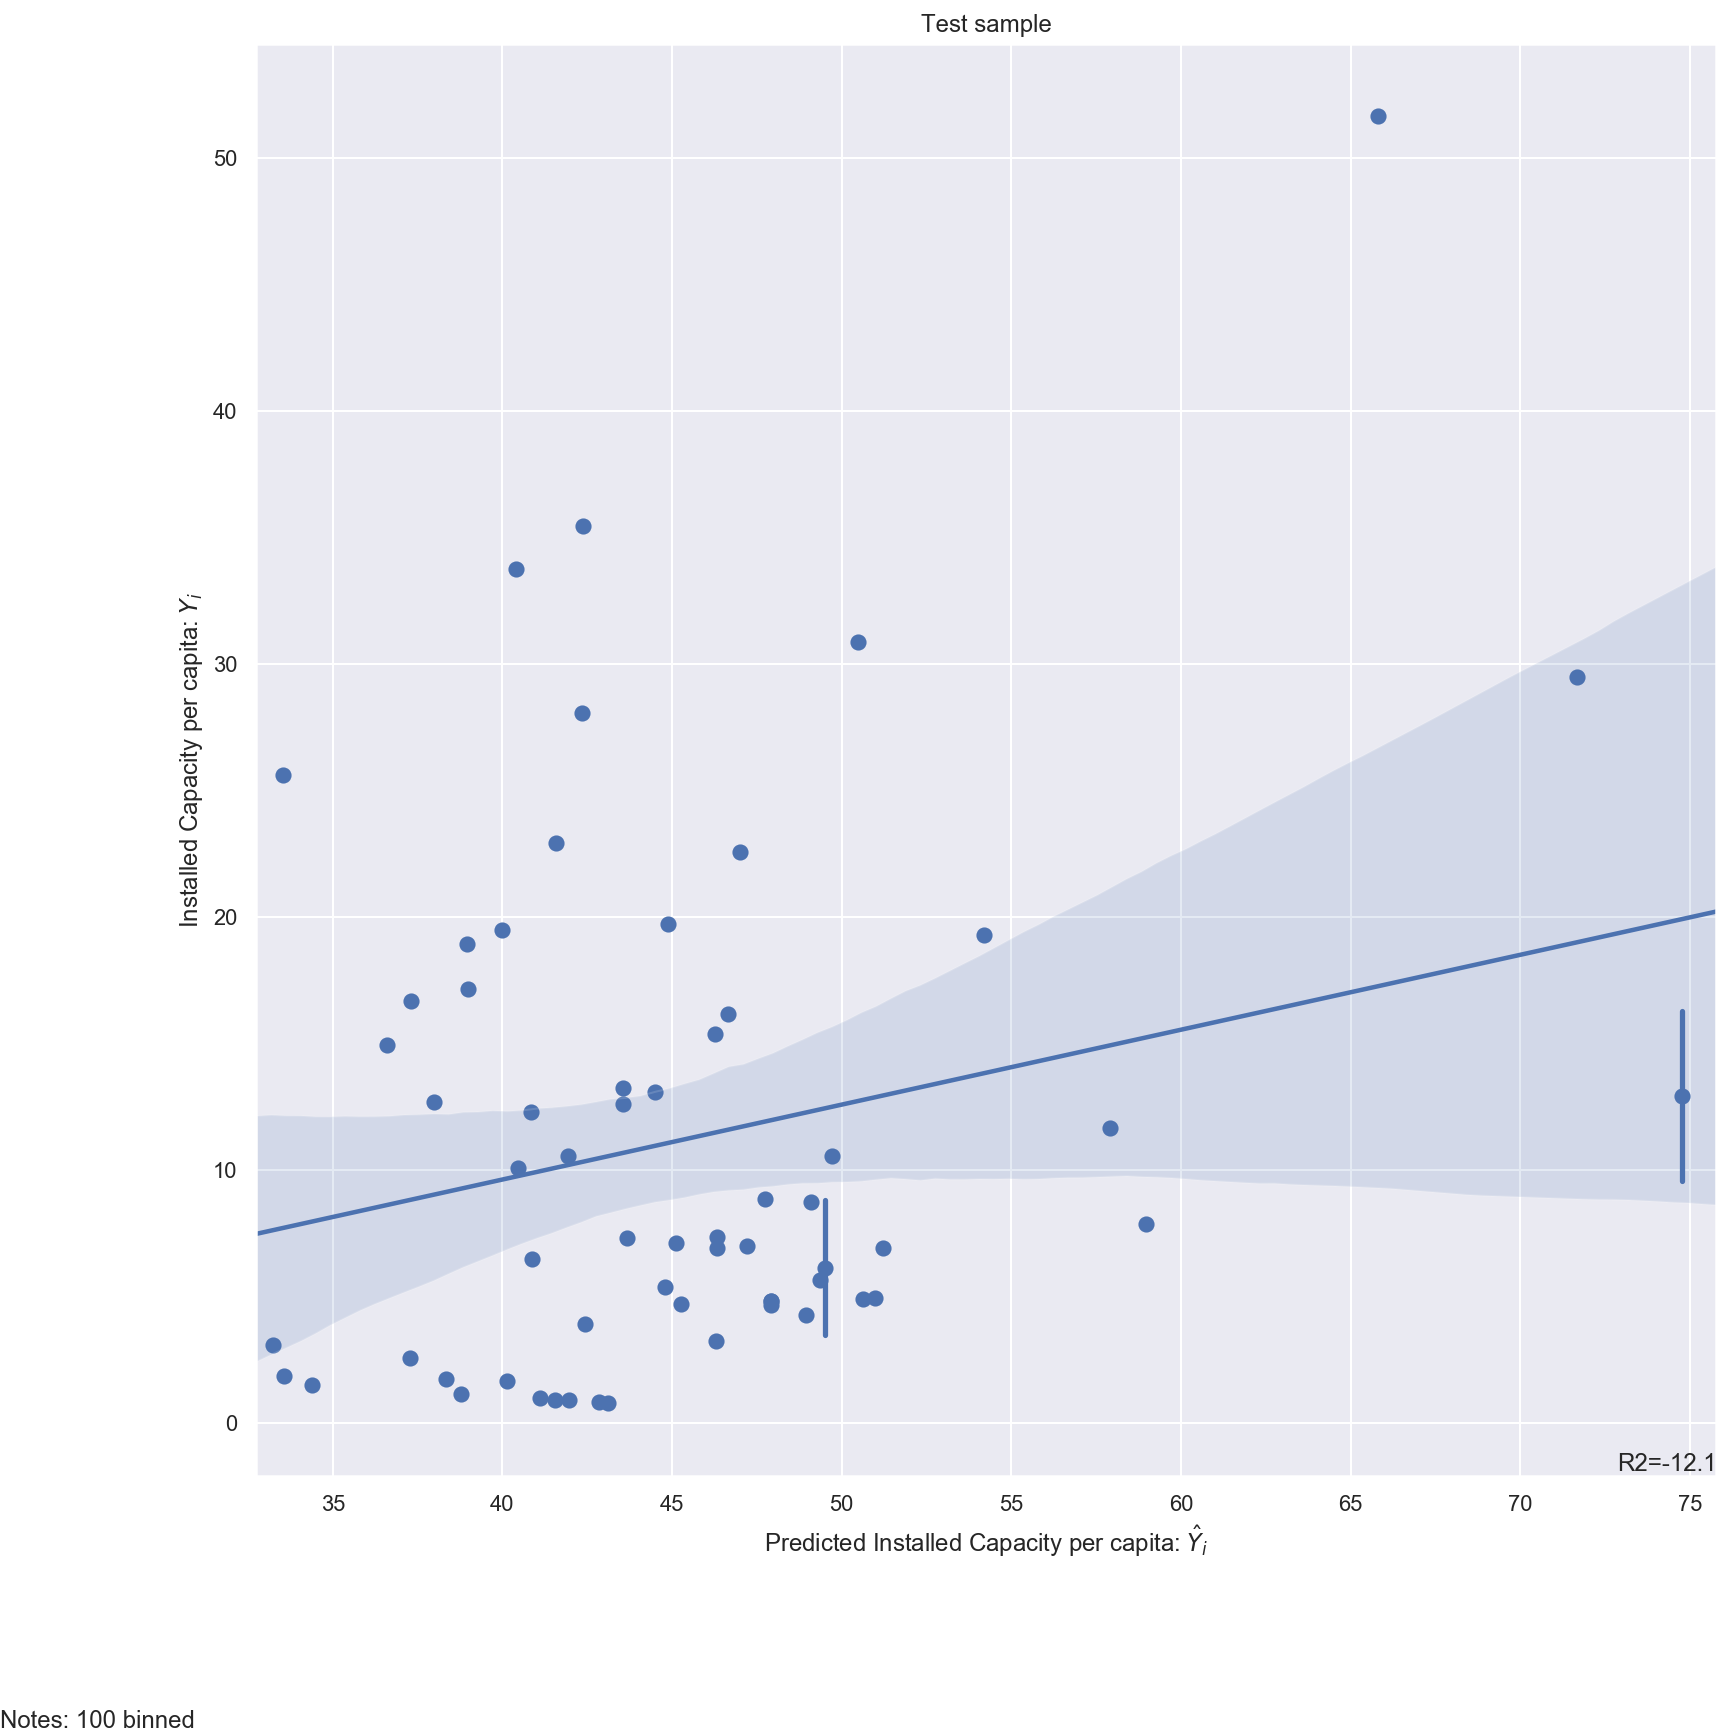

In [724]:
# Regplot
g=sns.regplot(x= Y_test_pred, y=Y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted Installed Capacity per capita: $\hat{Y}_i$")
plt.ylabel("Installed Capacity per capita: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
#plt.plot([-10000, 300000], [-10000, 300000], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

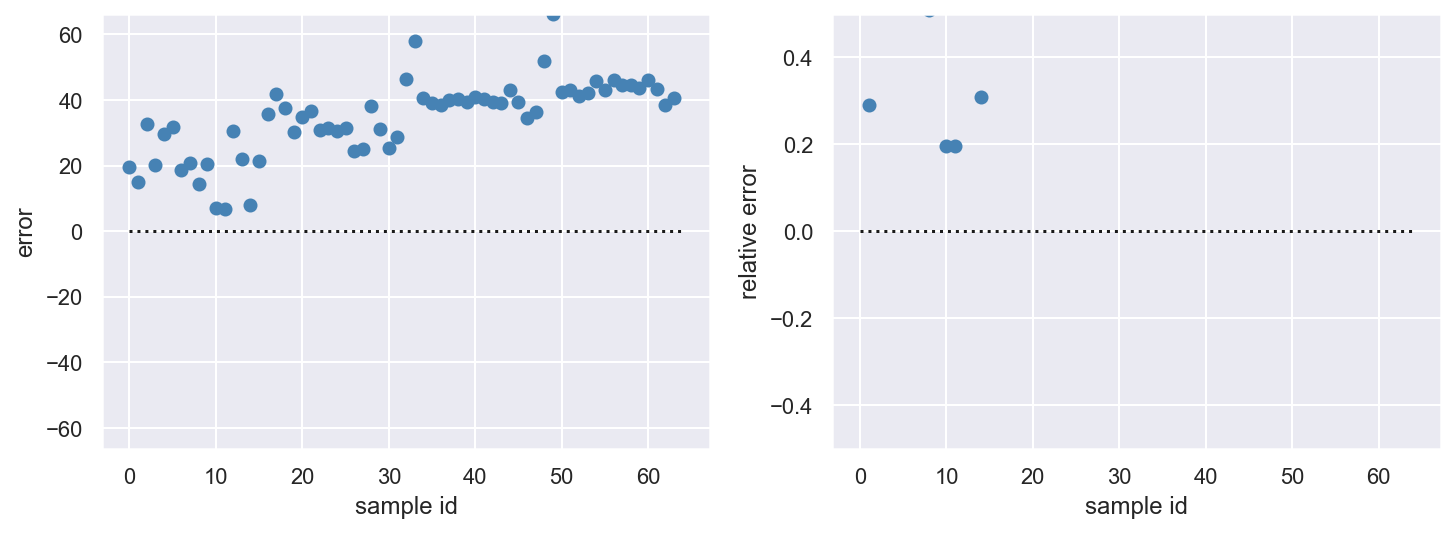

In [725]:
plot_fit_quality(Y_test, Y_test_pred)

[Text(0, 0.5, 'Installed Capacity per capita [W/cap]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Annually Installed PV Capacity per capita in Germany [<30kW]')]

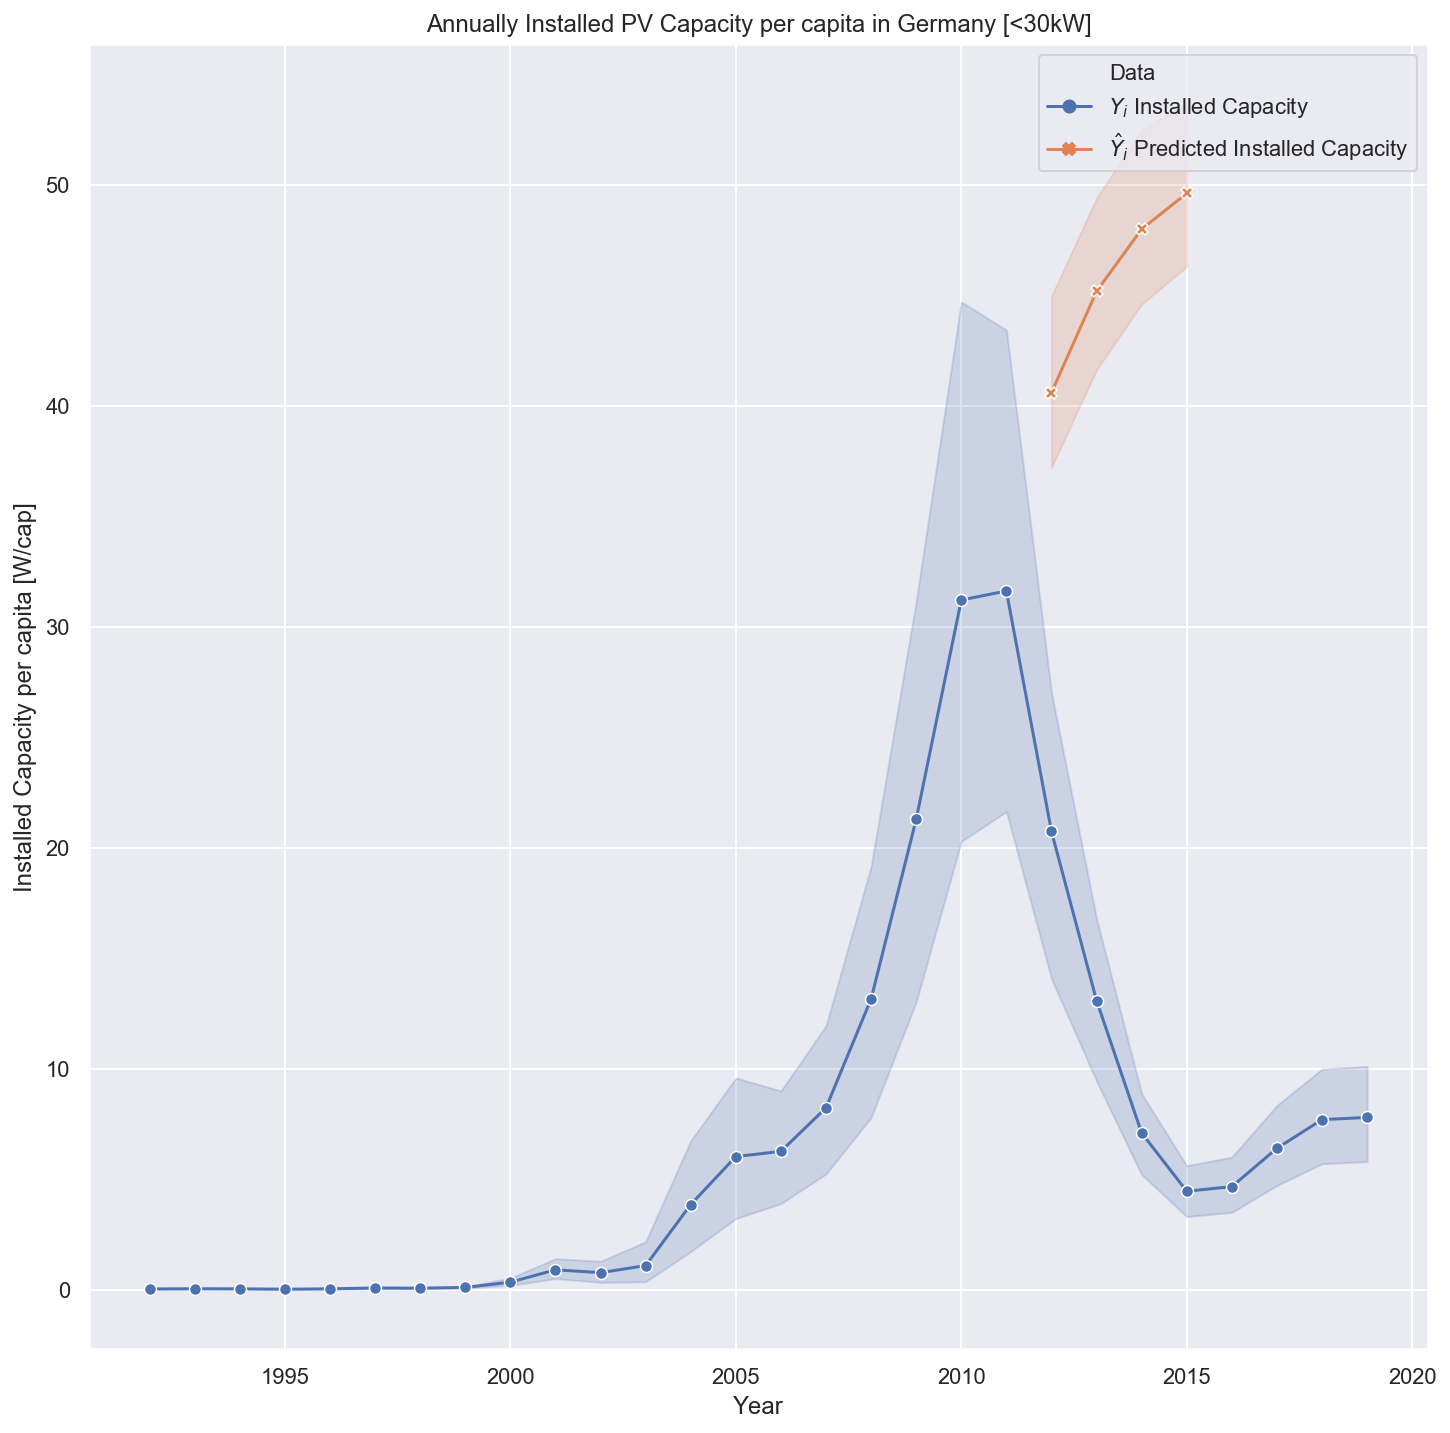

In [726]:
# extract the predicted data into a dataframe
df_pred = np.column_stack((Bundesland_test,X_test[:,0],Y_test,Y_test_pred))
df_pred = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test','Y_test_pred'])

# adjust data types
df_pred['Year'] = df_pred['Year'].astype(int)
df_pred['Y_test'] = df_pred['Y_test'].astype(float)
df_pred['Y_test_pred'] = df_pred['Y_test_pred'].astype(float)

# create a new dataframe for plotting the results
df_pred_plot = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test_pred'])

# create a new variable "Data" to classify the type of data
df_pred_plot['Data'] = "$\hat{Y}_i$ Predicted Installed Capacity"
df_pred_plot = df_pred_plot.rename(columns = {'Y_test_pred':'Y'})

# merge two data frames with actual and predicted data together
df_plot = pd.merge(Y, df_pred_plot , how='outer', on=['Year','Bundesland','Y','Data'])
df_plot = df_plot.sort_values(by=['Year','Bundesland'])

# plot the results
ax = sns.lineplot(x="Year", y="Y", hue="Data", style="Data", markers=True, dashes=False,
                  data=df_plot)
ax.set(xlabel="Year",
       ylabel="Installed Capacity per capita [W/cap]",
       title= "Annually Installed PV Capacity per capita in Germany [<30kW]")

### Ridge Regression

In [727]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1)       
ridge_reg.fit(X_train, Y_train)

Y_train_pred = ridge_reg.predict(X_train)
Y_test_pred = ridge_reg.predict(X_test) 

train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(Y_train, Y_train_pred), 4)) 
print("test R2: %s" % round(r2_score(Y_test, Y_test_pred), 4)) 

train RMS: 9.607401681615658
test RMS: 36.37305777076618
train R2: 0.6571
test R2: -12.0987


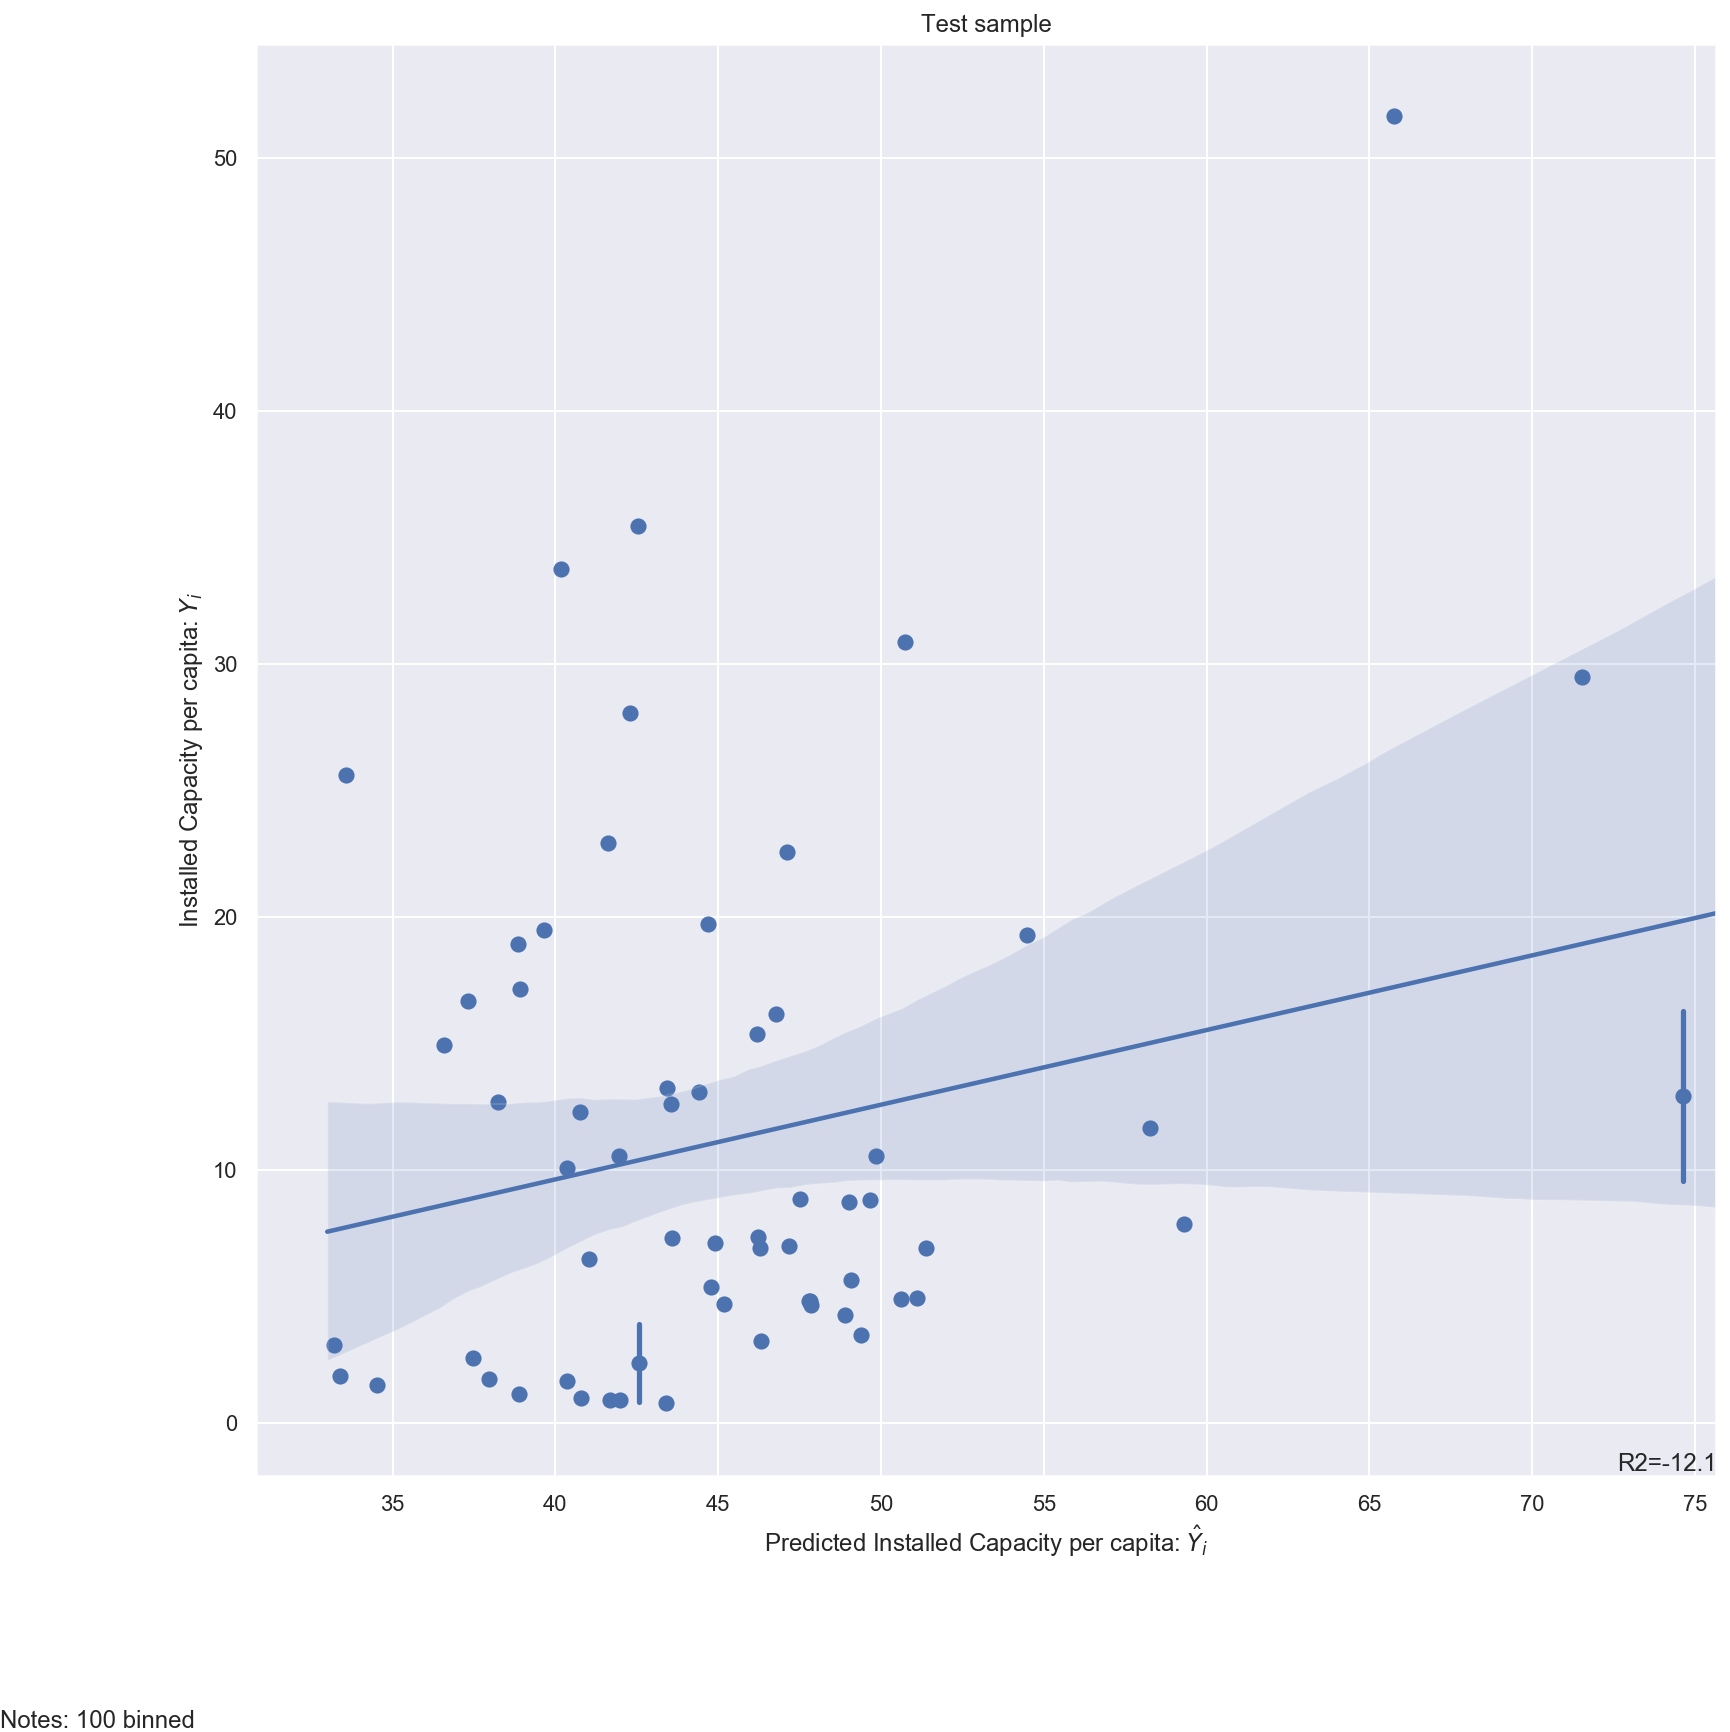

In [728]:
r2 = r2=round(r2_score(Y_test, Y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= Y_test_pred, y=Y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted Installed Capacity per capita: $\hat{Y}_i$")
plt.ylabel("Installed Capacity per capita: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
#plt.plot([110, 145], [110, 145], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

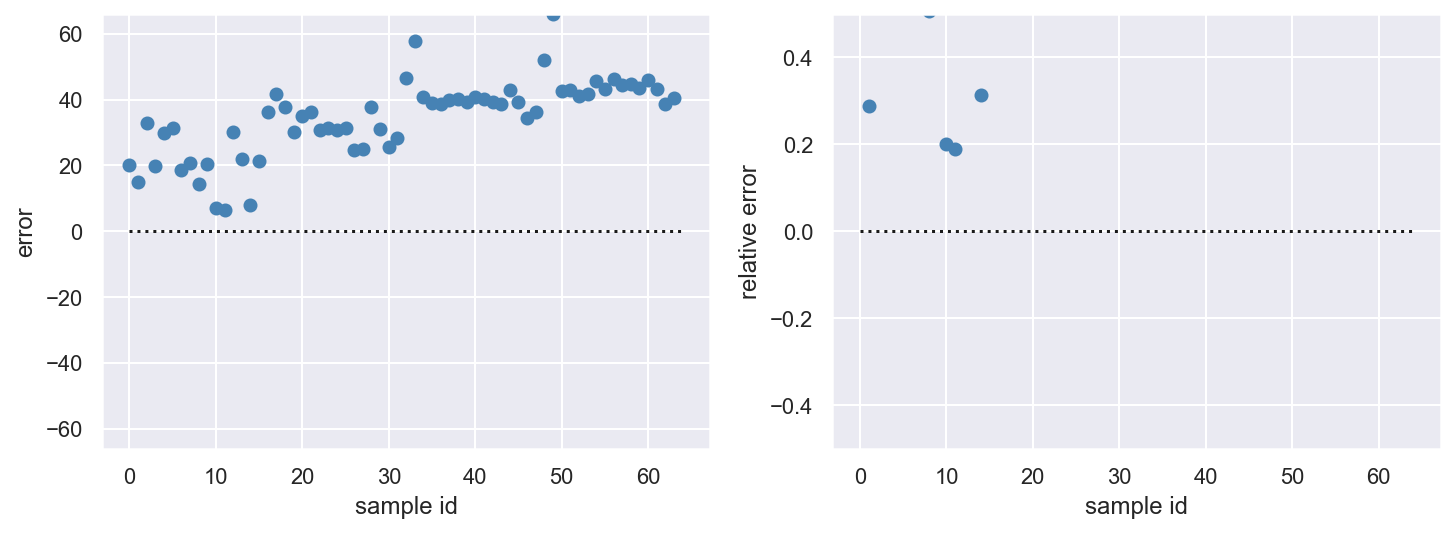

In [729]:
plot_fit_quality(Y_test, Y_test_pred)

[Text(0, 0.5, 'Installed Capacity per capita [W/cap]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Annually Installed PV Capacity per capita in Germany [<30kW]')]

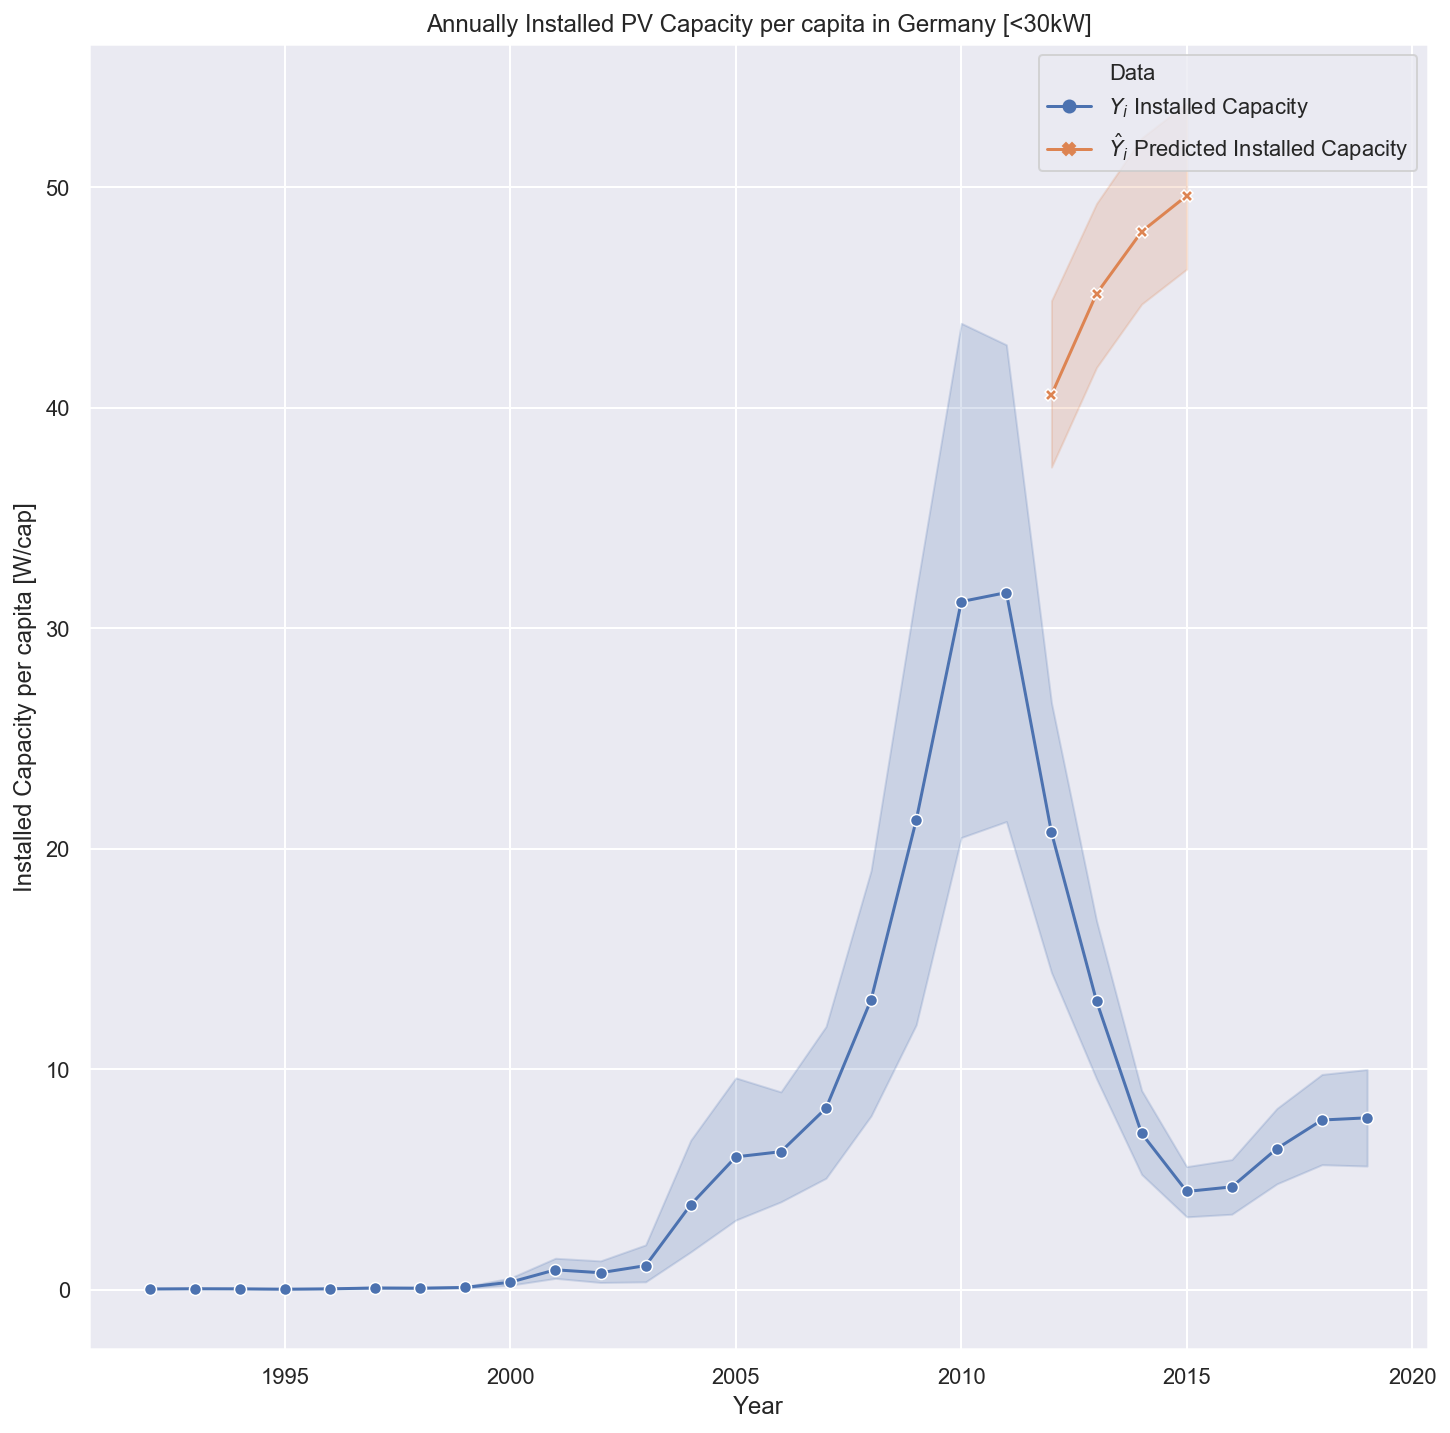

In [730]:
# extract the predicted data into a dataframe
df_pred = np.column_stack((Bundesland_test,X_test[:,0],Y_test,Y_test_pred))
df_pred = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test','Y_test_pred'])

# adjust data types
df_pred['Year'] = df_pred['Year'].astype(int)
df_pred['Y_test'] = df_pred['Y_test'].astype(float)
df_pred['Y_test_pred'] = df_pred['Y_test_pred'].astype(float)

# create a new dataframe for plotting the results
df_pred_plot = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test_pred'])

# create a new variable "Data" to classify the type of data
df_pred_plot['Data'] = "$\hat{Y}_i$ Predicted Installed Capacity"
df_pred_plot = df_pred_plot.rename(columns = {'Y_test_pred':'Y'})

# merge two data frames with actual and predicted data together
df_plot = pd.merge(Y, df_pred_plot , how='outer', on=['Year','Bundesland','Y','Data'])
df_plot = df_plot.sort_values(by=['Year','Bundesland'])

# plot the results
ax = sns.lineplot(x="Year", y="Y", hue="Data", style="Data", markers=True, dashes=False,
                  data=df_plot)
ax.set(xlabel="Year",
       ylabel="Installed Capacity per capita [W/cap]",
       title= "Annually Installed PV Capacity per capita in Germany [<30kW]")

### Polynomial Regression

In [731]:
from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=3)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, Y_train)

Y_train_pred = lin_reg.predict(X_train_poly)
Y_test_pred = lin_reg.predict(X_test_poly)

train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(Y_test,Y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(Y_train, Y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(Y_test, Y_test_pred), 2))

train RMS: 3.540646622643782
test RMS: 79.50675571554015
train R2: 0.95
test R2: -61.59


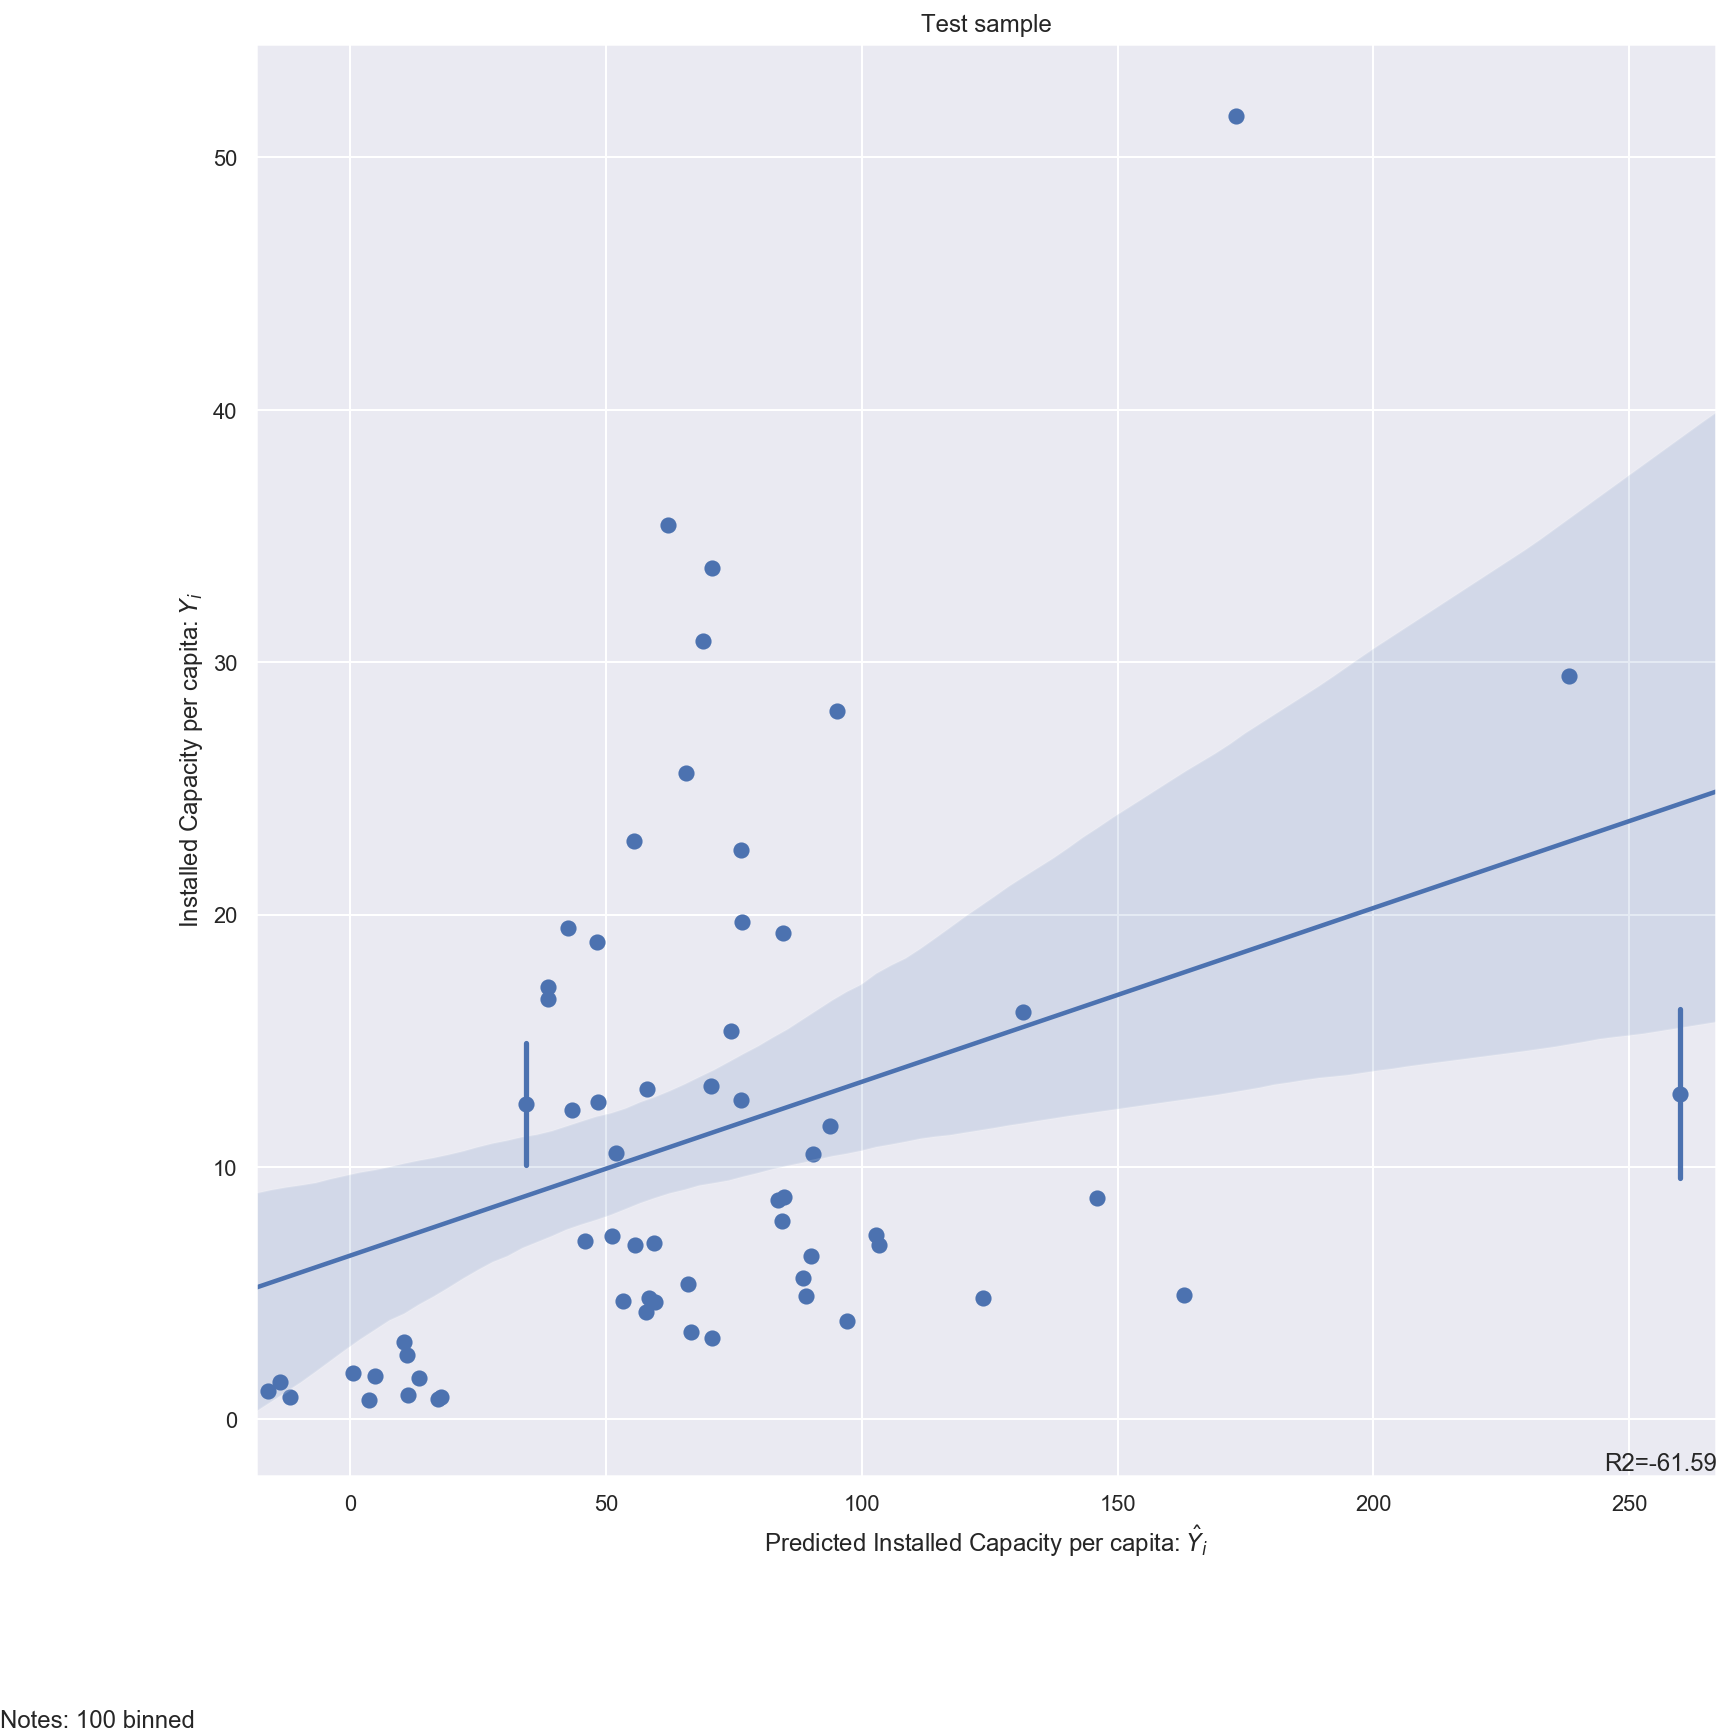

In [732]:
r2 = r2=round(r2_score(Y_test, Y_test_pred), 2)

# Regplot
g=sns.regplot(x= Y_test_pred, y=Y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted Installed Capacity per capita: $\hat{Y}_i$")
plt.ylabel("Installed Capacity per capita: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
#plt.plot([0, 100], [0, 100], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

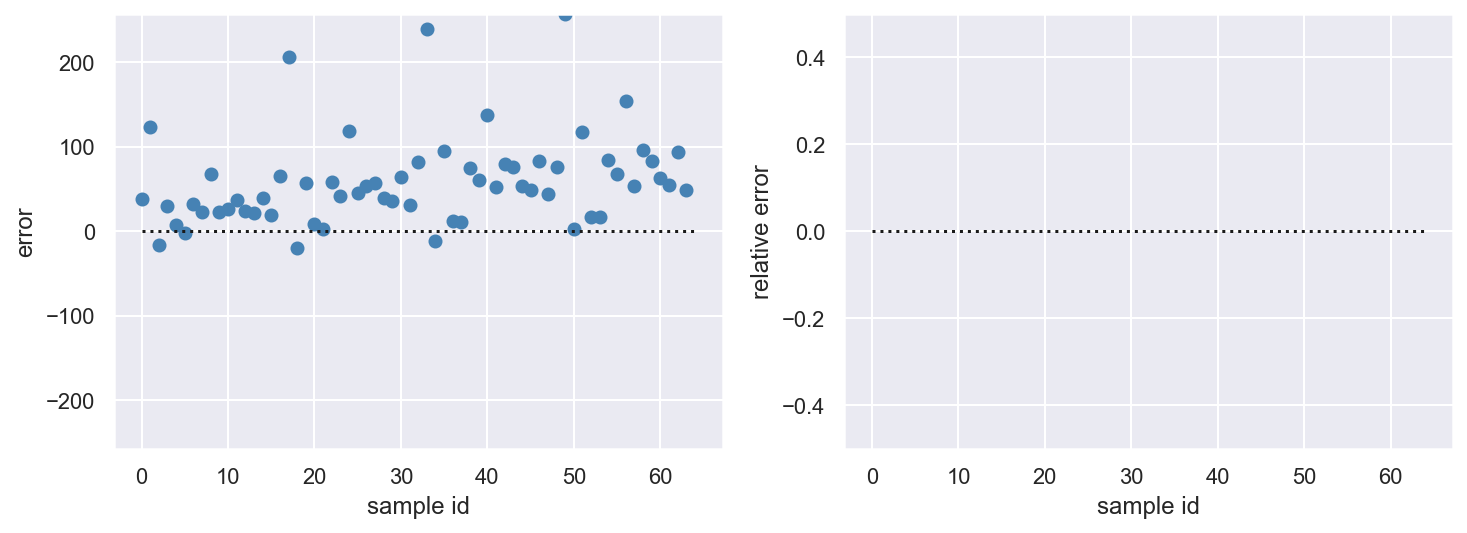

In [733]:
plot_fit_quality(Y_test, Y_test_pred)

[Text(0, 0.5, 'Installed Capacity per capita [W/cap]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Annually Installed PV Capacity per capita in Germany [<30kW]')]

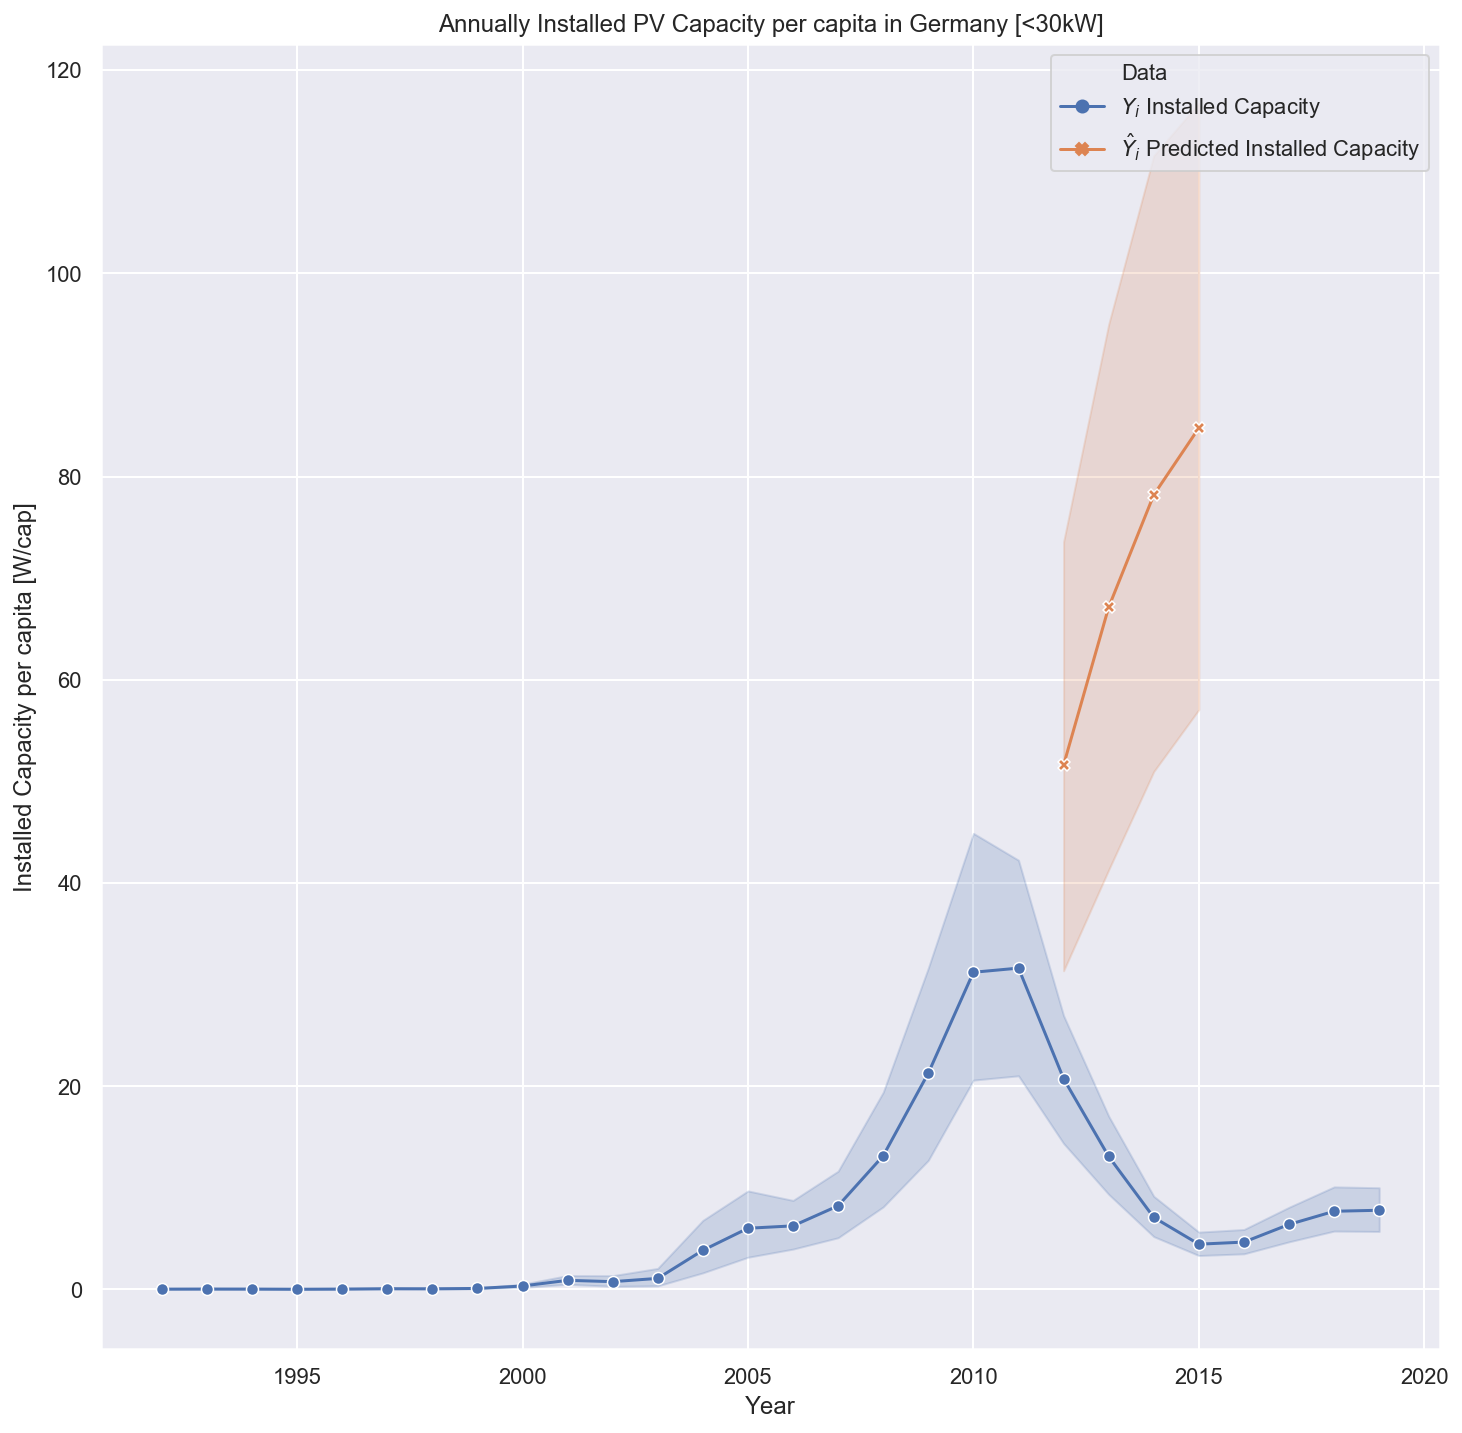

In [734]:
# extract the predicted data into a dataframe
df_pred = np.column_stack((Bundesland_test,X_test[:,0],Y_test,Y_test_pred))
df_pred = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test','Y_test_pred'])

# adjust data types
df_pred['Year'] = df_pred['Year'].astype(int)
df_pred['Y_test'] = df_pred['Y_test'].astype(float)
df_pred['Y_test_pred'] = df_pred['Y_test_pred'].astype(float)

# create a new dataframe for plotting the results
df_pred_plot = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test_pred'])

# create a new variable "Data" to classify the type of data
df_pred_plot['Data'] = "$\hat{Y}_i$ Predicted Installed Capacity"
df_pred_plot = df_pred_plot.rename(columns = {'Y_test_pred':'Y'})

# merge two data frames with actual and predicted data together
df_plot = pd.merge(Y, df_pred_plot , how='outer', on=['Year','Bundesland','Y','Data'])
df_plot = df_plot.sort_values(by=['Year','Bundesland'])

# plot the results
ax = sns.lineplot(x="Year", y="Y", hue="Data", style="Data", markers=True, dashes=False,
                  data=df_plot)
ax.set(xlabel="Year",
       ylabel="Installed Capacity per capita [W/cap]",
       title= "Annually Installed PV Capacity per capita in Germany [<30kW]")

### Lasso regression

In [644]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=1) 

lasso_reg.fit(X_train, Y_train)

Y_train_pred = lasso_reg.predict(X_train) 
Y_test_pred = lasso_reg.predict(X_test)        

train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(Y_train, Y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(Y_test, Y_test_pred), 2))

train RMS: 3.0386665270880764
test RMS: 15.968503782713766
train R2: 0.66
test R2: -0.02


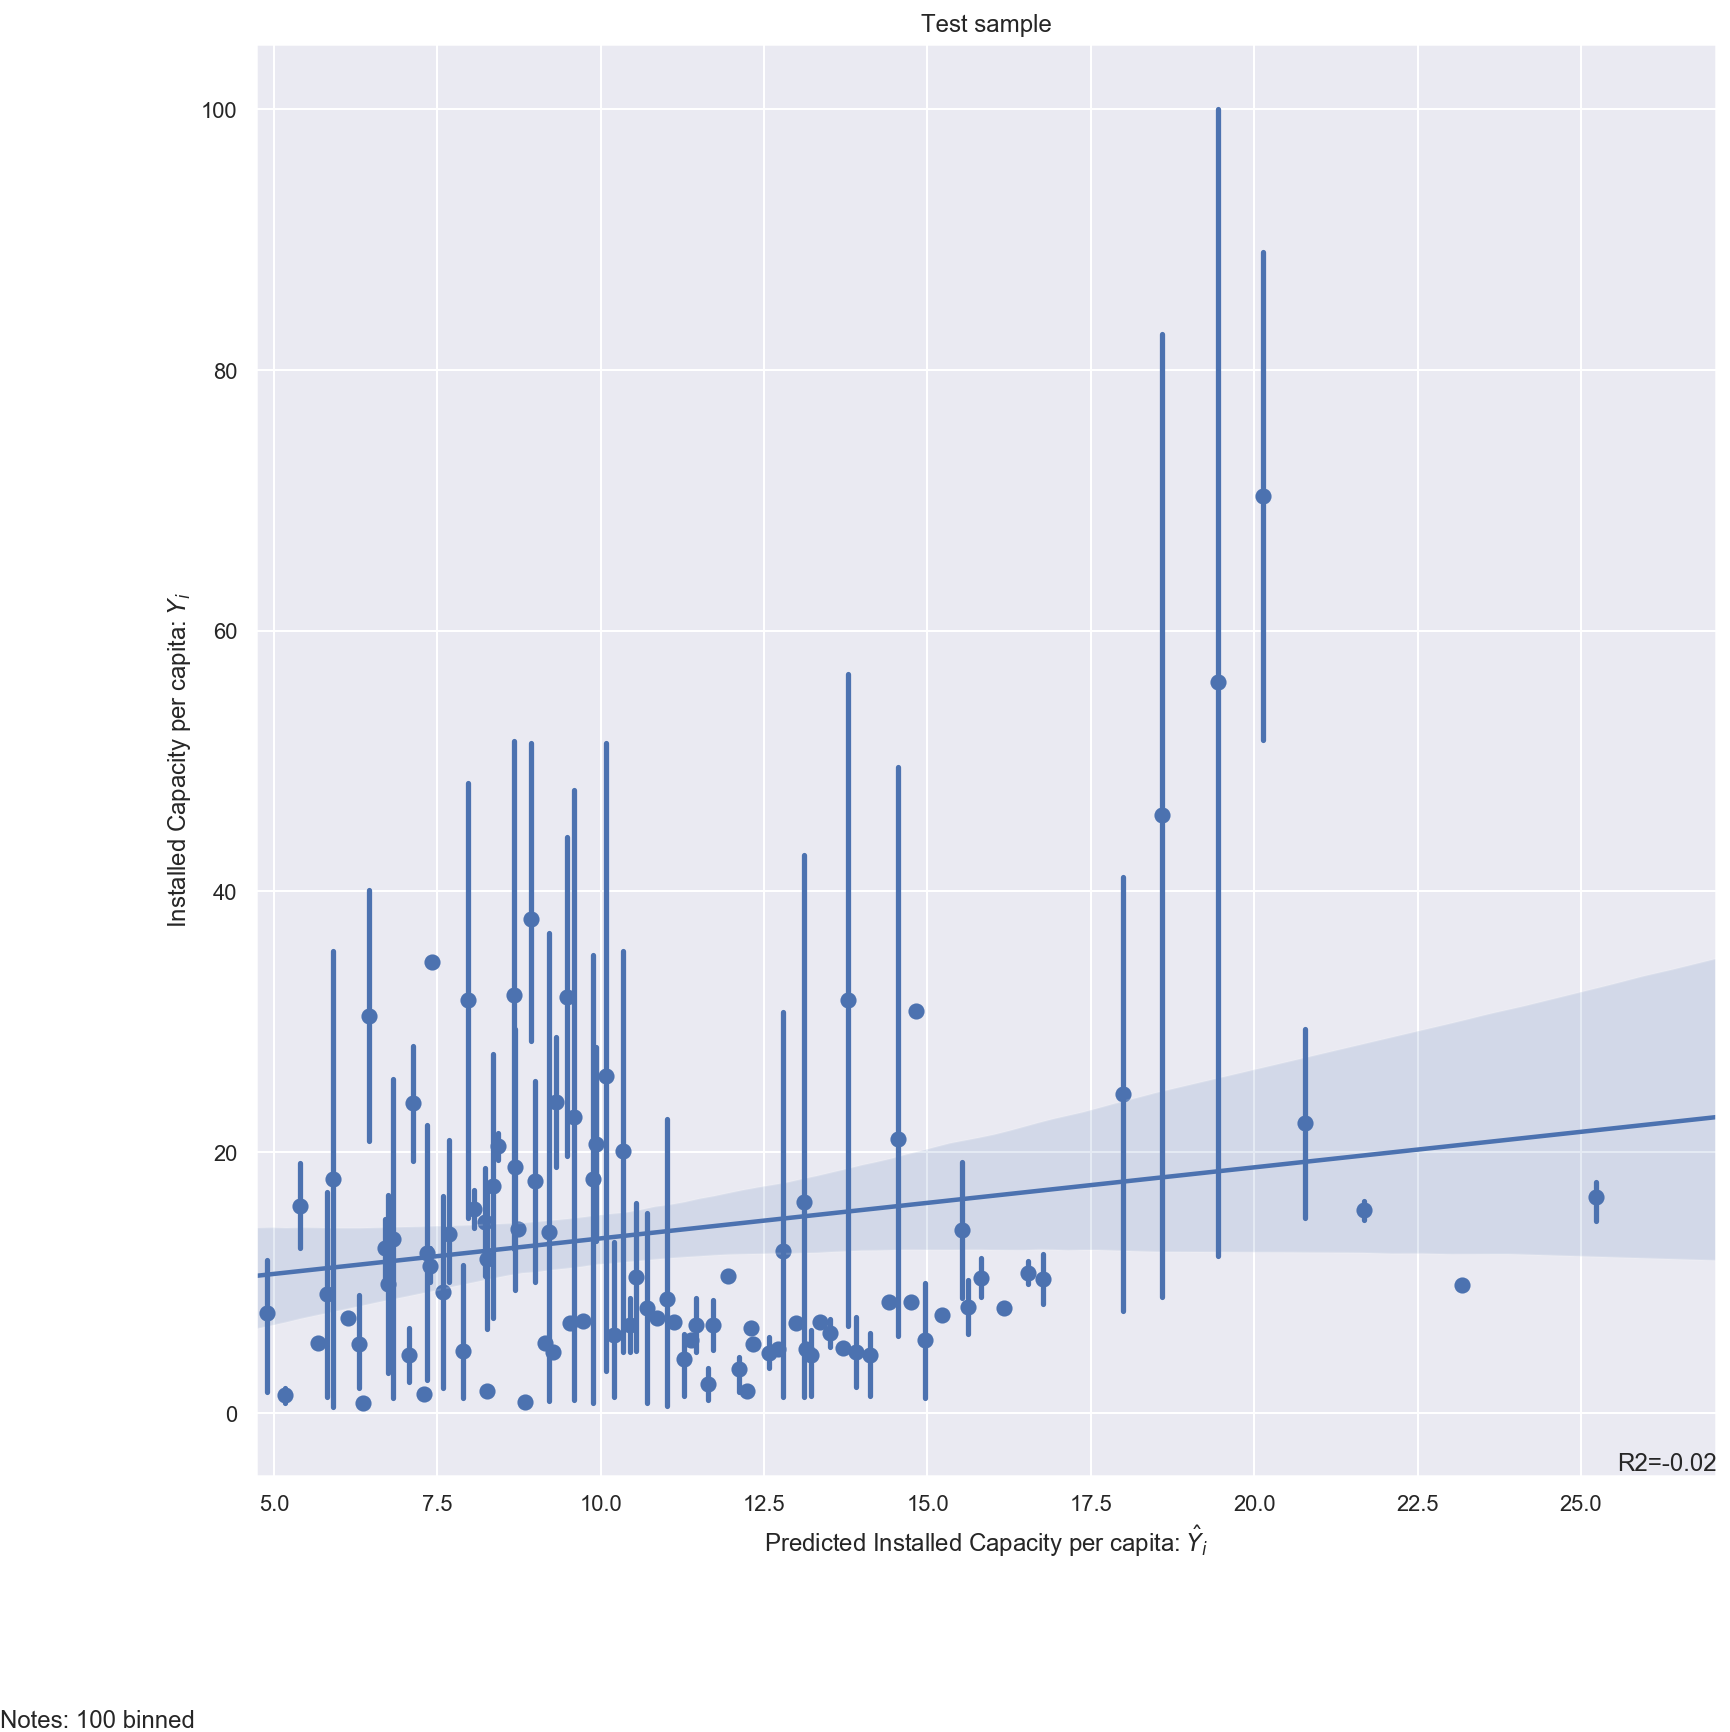

In [645]:
r2 = r2=round(r2_score(Y_test, Y_test_pred), 2)

# Regplot
g=sns.regplot(x= Y_test_pred, y=Y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted Installed Capacity per capita: $\hat{Y}_i$")
plt.ylabel("Installed Capacity per capita: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
#plt.plot([-10000, 300000], [-10000, 300000], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

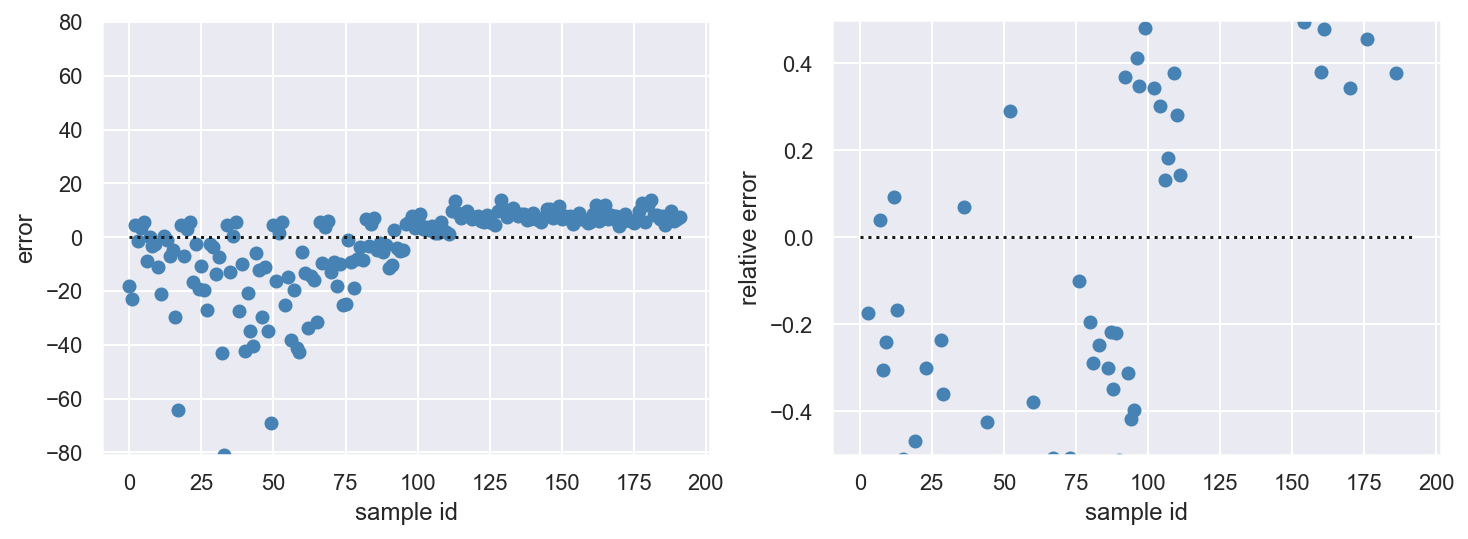

In [646]:
plot_fit_quality(Y_test, Y_test_pred)

[Text(0, 0.5, 'Installed Capacity per capita [W/cap]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Annually Installed PV Capacity per capita in Germany [<30kW]')]

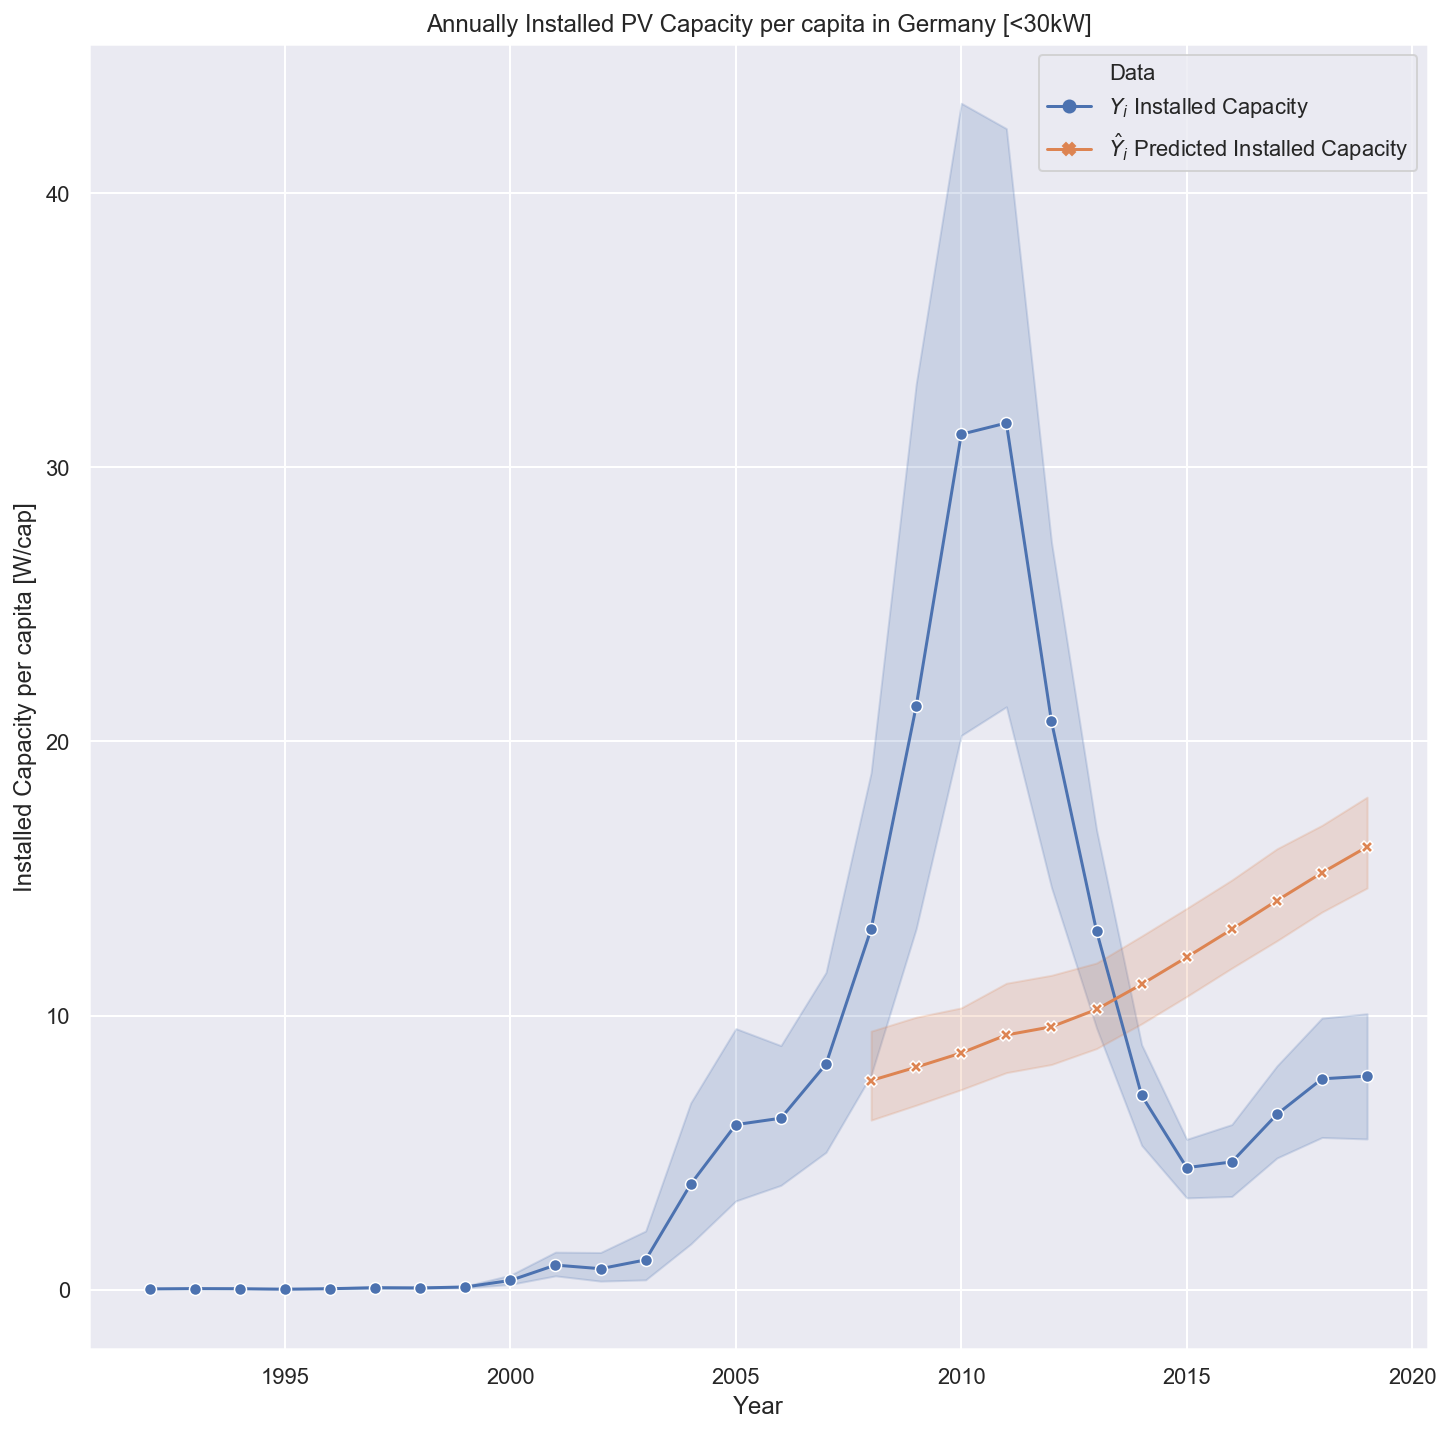

In [647]:
# extract the predicted data into a dataframe
df_pred = np.column_stack((Bundesland_test,X_test[:,0],Y_test,Y_test_pred))
df_pred = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test','Y_test_pred'])

# adjust data types
df_pred['Year'] = df_pred['Year'].astype(int)
df_pred['Y_test'] = df_pred['Y_test'].astype(float)
df_pred['Y_test_pred'] = df_pred['Y_test_pred'].astype(float)

# create a new dataframe for plotting the results
df_pred_plot = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test_pred'])

# create a new variable "Data" to classify the type of data
df_pred_plot['Data'] = "$\hat{Y}_i$ Predicted Installed Capacity"
df_pred_plot = df_pred_plot.rename(columns = {'Y_test_pred':'Y'})

# merge two data frames with actual and predicted data together
df_plot = pd.merge(Y, df_pred_plot , how='outer', on=['Year','Bundesland','Y','Data'])
df_plot = df_plot.sort_values(by=['Year','Bundesland'])

# plot the results
ax = sns.lineplot(x="Year", y="Y", hue="Data", style="Data", markers=True, dashes=False,
                  data=df_plot)
ax.set(xlabel="Year",
       ylabel="Installed Capacity per capita [W/cap]",
       title= "Annually Installed PV Capacity per capita in Germany [<30kW]")

### Elastic net

In [648]:
from sklearn.linear_model import ElasticNet
elanet_reg=ElasticNet(random_state=0)

elanet_reg.fit(X_train, Y_train)

Y_train_pred = elanet_reg.predict(X_train)
Y_test_pred = elanet_reg.predict(X_test)

train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(Y_train, Y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(Y_test, Y_test_pred), 2))

train RMS: 3.0295310220332117
test RMS: 15.958559065726211
train R2: 0.67
test R2: -0.02


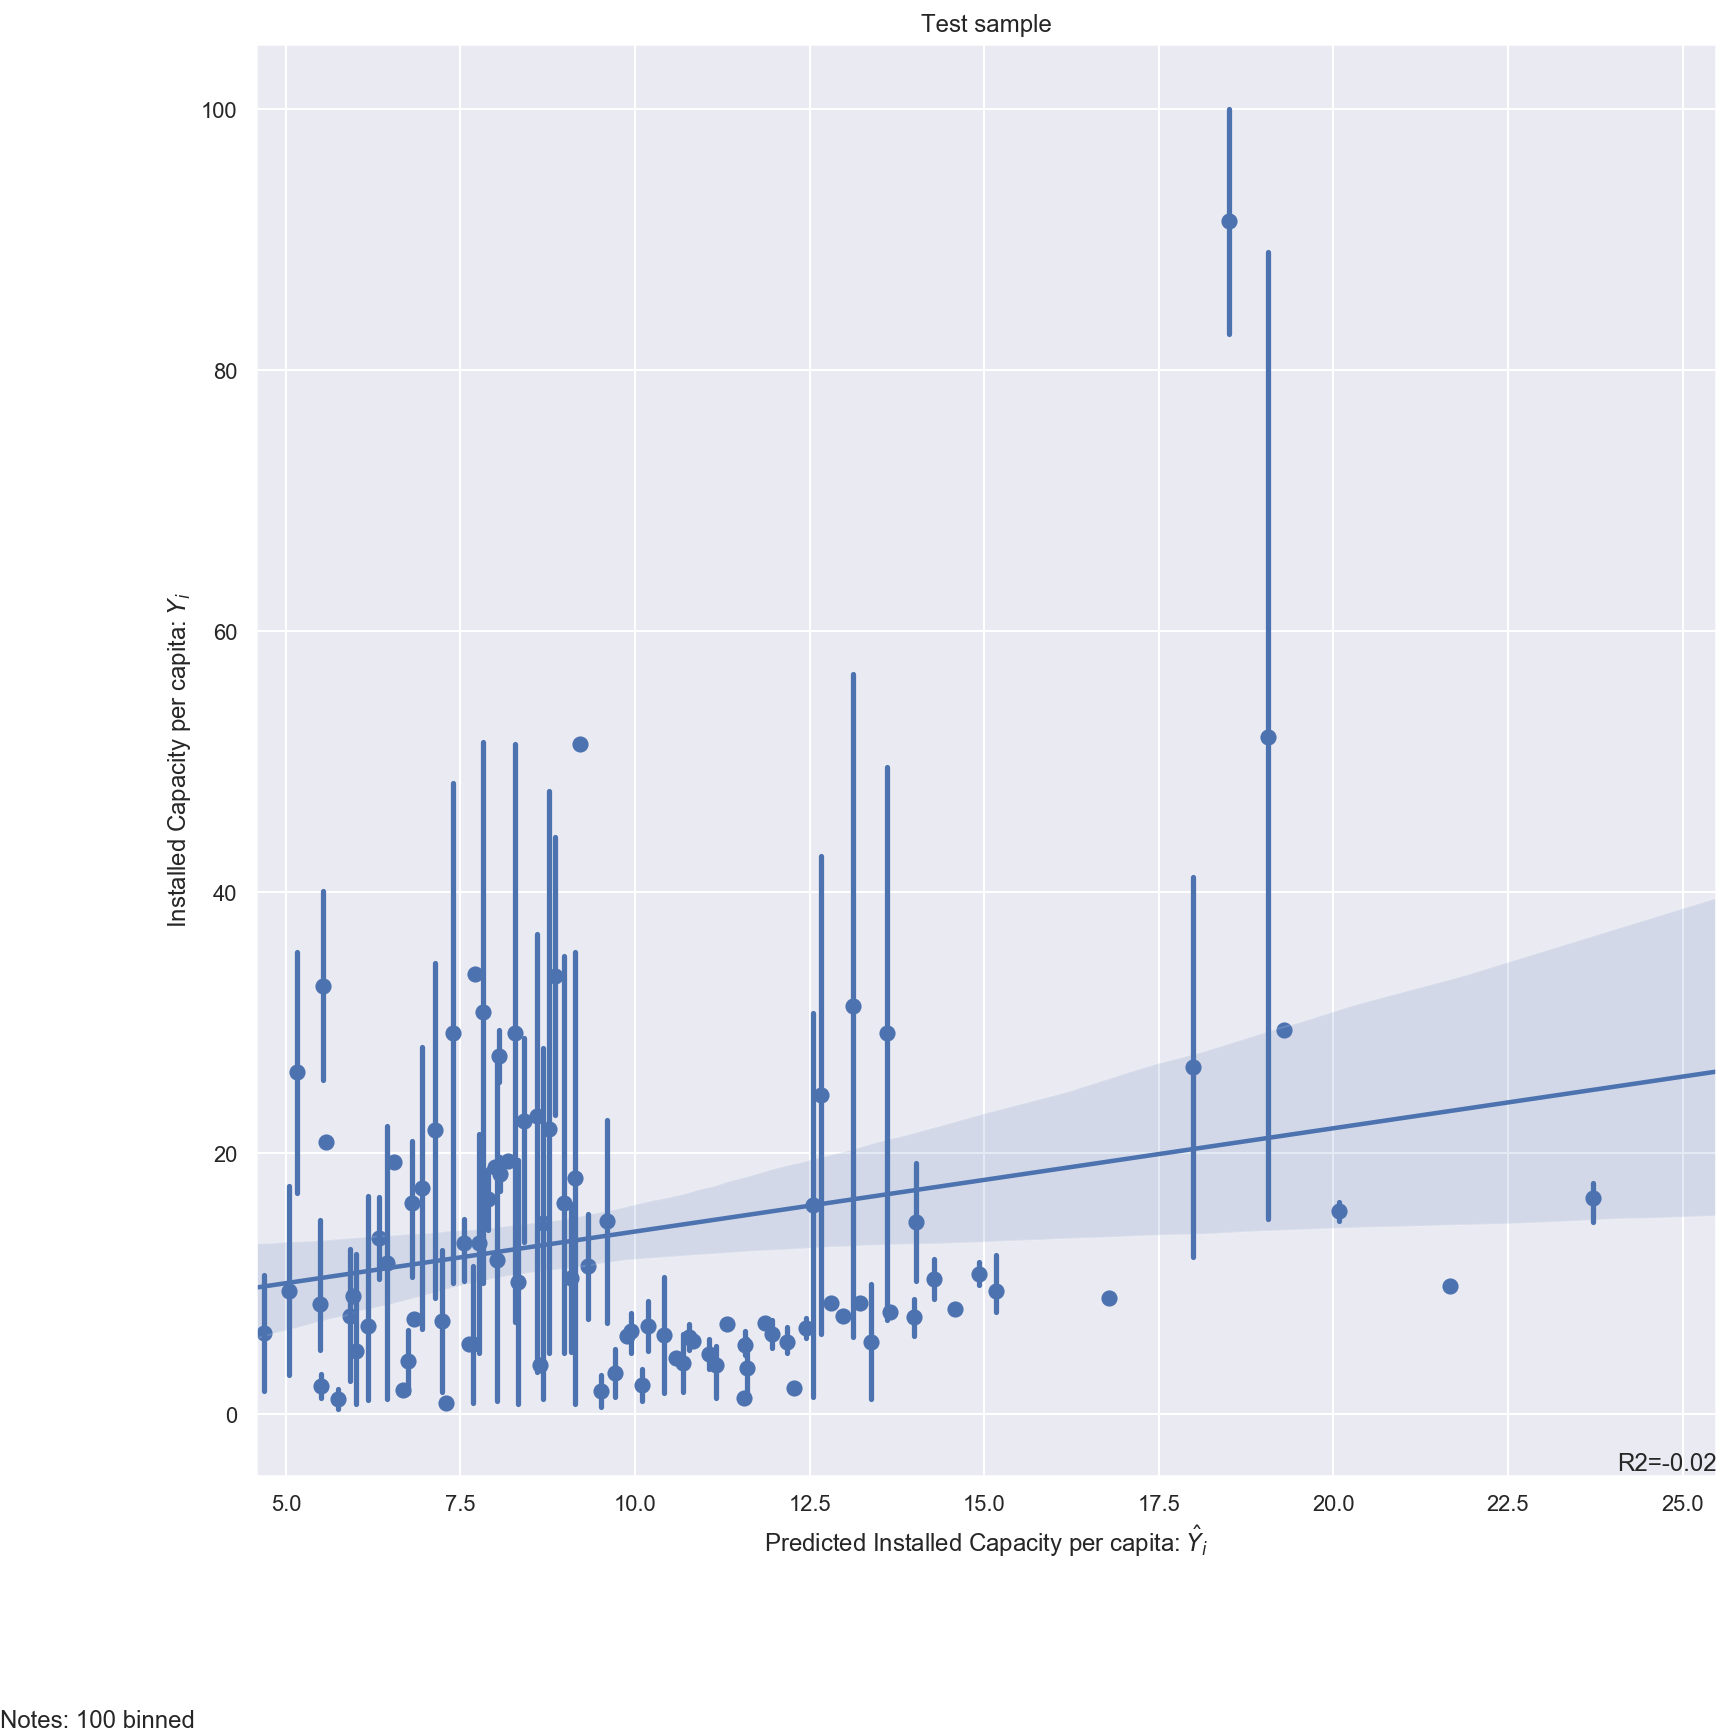

In [649]:
r2 = r2=round(r2_score(Y_test, Y_test_pred), 2)

# Regplot
g=sns.regplot(x= Y_test_pred, y=Y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted Installed Capacity per capita: $\hat{Y}_i$")
plt.ylabel("Installed Capacity per capita: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
#plt.plot([-10000, 300000], [-10000, 300000], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

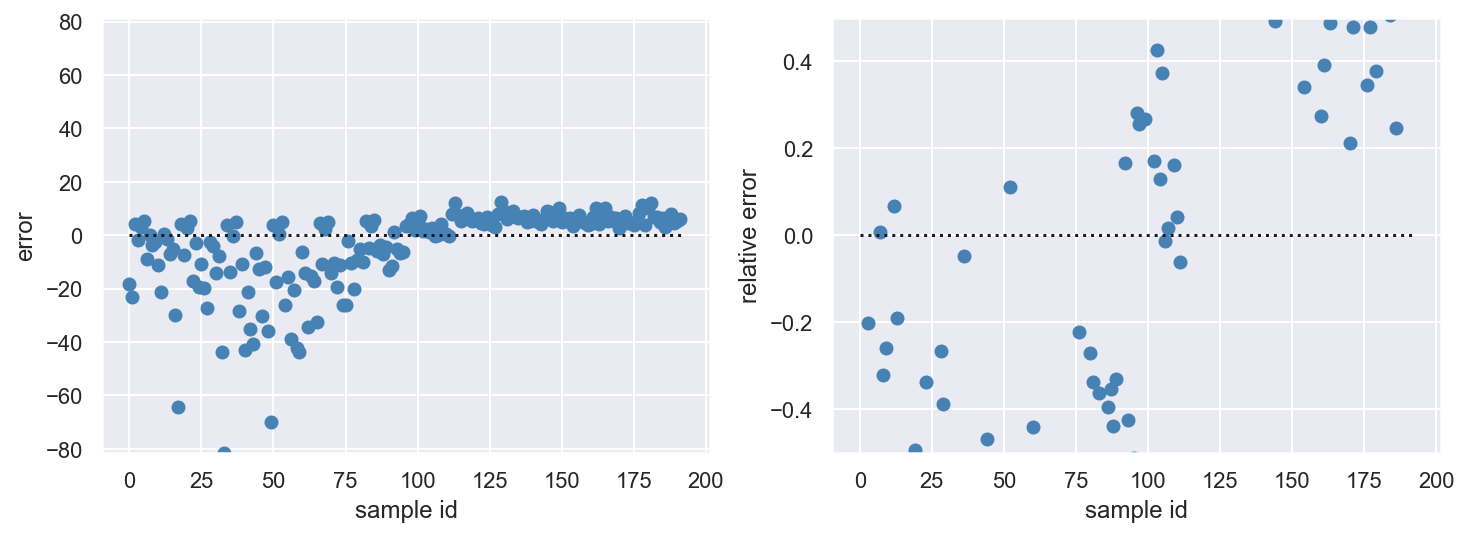

In [650]:
plot_fit_quality(Y_test, Y_test_pred)

[Text(0, 0.5, 'Installed Capacity per capita [W/cap]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Annually Installed PV Capacity per capita in Germany [<30kW]')]

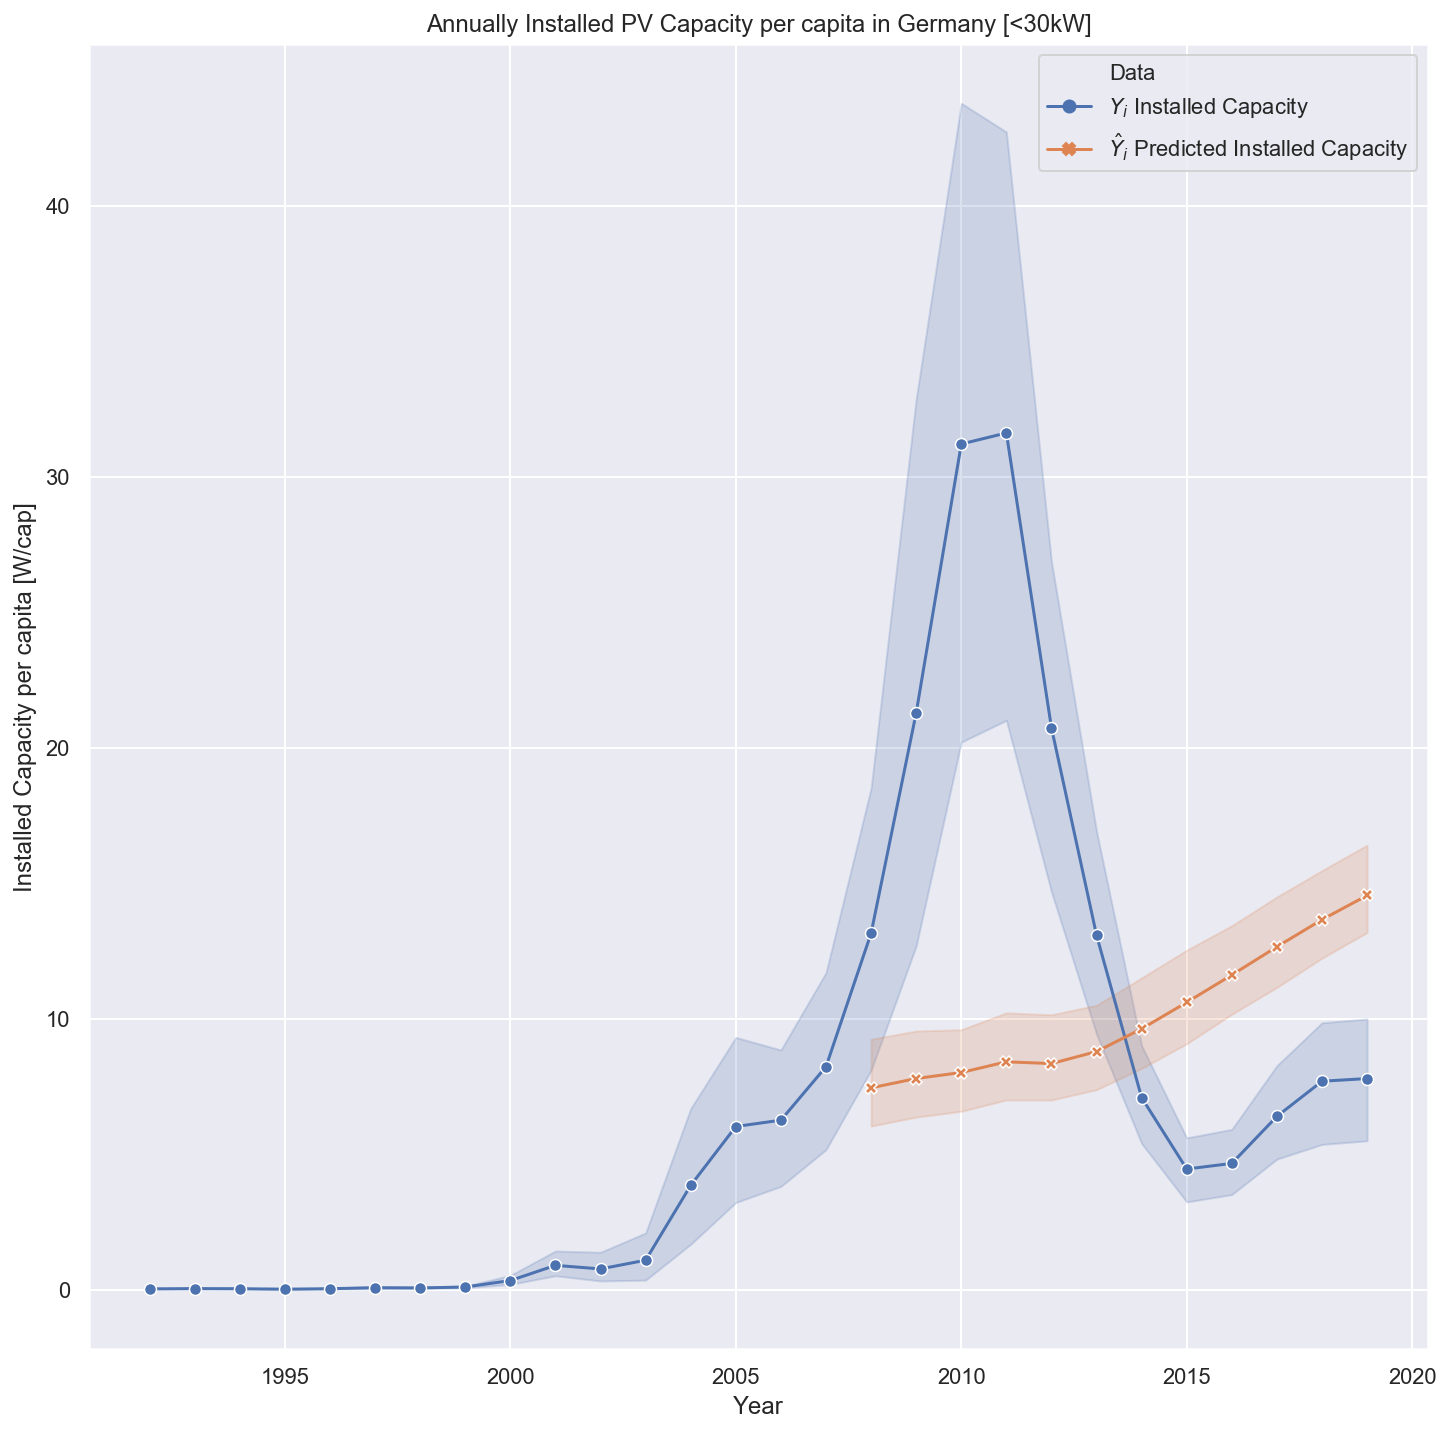

In [651]:
# extract the predicted data into a dataframe
df_pred = np.column_stack((Bundesland_test,X_test[:,0],Y_test,Y_test_pred))
df_pred = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test','Y_test_pred'])

# adjust data types
df_pred['Year'] = df_pred['Year'].astype(int)
df_pred['Y_test'] = df_pred['Y_test'].astype(float)
df_pred['Y_test_pred'] = df_pred['Y_test_pred'].astype(float)

# create a new dataframe for plotting the results
df_pred_plot = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test_pred'])

# create a new variable "Data" to classify the type of data
df_pred_plot['Data'] = "$\hat{Y}_i$ Predicted Installed Capacity"
df_pred_plot = df_pred_plot.rename(columns = {'Y_test_pred':'Y'})

# merge two data frames with actual and predicted data together
df_plot = pd.merge(Y, df_pred_plot , how='outer', on=['Year','Bundesland','Y','Data'])
df_plot = df_plot.sort_values(by=['Year','Bundesland'])

# plot the results
ax = sns.lineplot(x="Year", y="Y", hue="Data", style="Data", markers=True, dashes=False,
                  data=df_plot)
ax.set(xlabel="Year",
       ylabel="Installed Capacity per capita [W/cap]",
       title= "Annually Installed PV Capacity per capita in Germany [<30kW]")

## Shifted Data

A different approach using shifted feed-in data. The feed-in was shifted +6 years so that the feed-in peak coincides with the annually installed capacity peak (see graph below). This approach takes the delay between policy adaptation and commissioning of the PV modules on the roof-top.

In [795]:
# load the csv data from my online repository
data_shifted = pd.read_excel('https://raw.githubusercontent.com/eckmanna/big_data_policy_2020/master/course_project/data/df_pv_data_germany_fit-shifted.xlsx').iloc[:, :] #avoiding "unnamed"-row
df1_shifted = data_shifted[(data_shifted.Year>=1992) & (data_shifted.Year<2020)]

# X from datafram to array
X_full = df1_shifted[['Year','module_cost','feed-in','population','area','GDP_pc','solar_irradiance','sun_hours','share_green_party']].to_numpy()
# use both population and area, rather than population density only
print(X_full.shape)

# Y from datafram to array
Y_full = df1_shifted['Installed_Cap_below_30_pc'].to_numpy()
print(Y_full.shape)

# Bundeslaender from dataframe to array
Bundesland_full = df1_shifted['Bundesland'].to_numpy()
print(Bundesland_full.shape)

# X from array to dataframe
X_df = pd.DataFrame(X_full, columns=['Year','module_cost','feed-in','population','area','GDP_pc','solar_irradiance','sun_hours','share_green_party'])
#X_df = pd.DataFrame(X_full, columns=['Year','module_cost','feed-in','solar_irradiance','sun_hours','share_green_party'])
# Format year
X_df['Year'] = pd.to_datetime(X_df['Year'], format='%Y').dt.year
X_df.head()

(448, 9)
(448,)
(448,)


Year  module_cost  feed-in  population      area        GDP_pc  \
0  1992          8.0      NaN  10148708.0  35673.71  25211.682118   
1  1992          8.0      NaN  11770257.0  70542.03  24053.935271   
2  1992          8.0      NaN   3465748.0    891.12  21713.061654   
3  1992          8.0      NaN   2542651.0  29654.38   9657.636852   
4  1992          8.0      NaN    685845.0    419.84  28325.642091   

   solar_irradiance  sun_hours  share_green_party  
0            1100.0     1755.0              0.095  
1            1180.0     1805.0              0.064  
2            1009.0     1590.0              0.094  
3            1005.0     1615.0              0.093  
4             980.0     1455.0              0.114

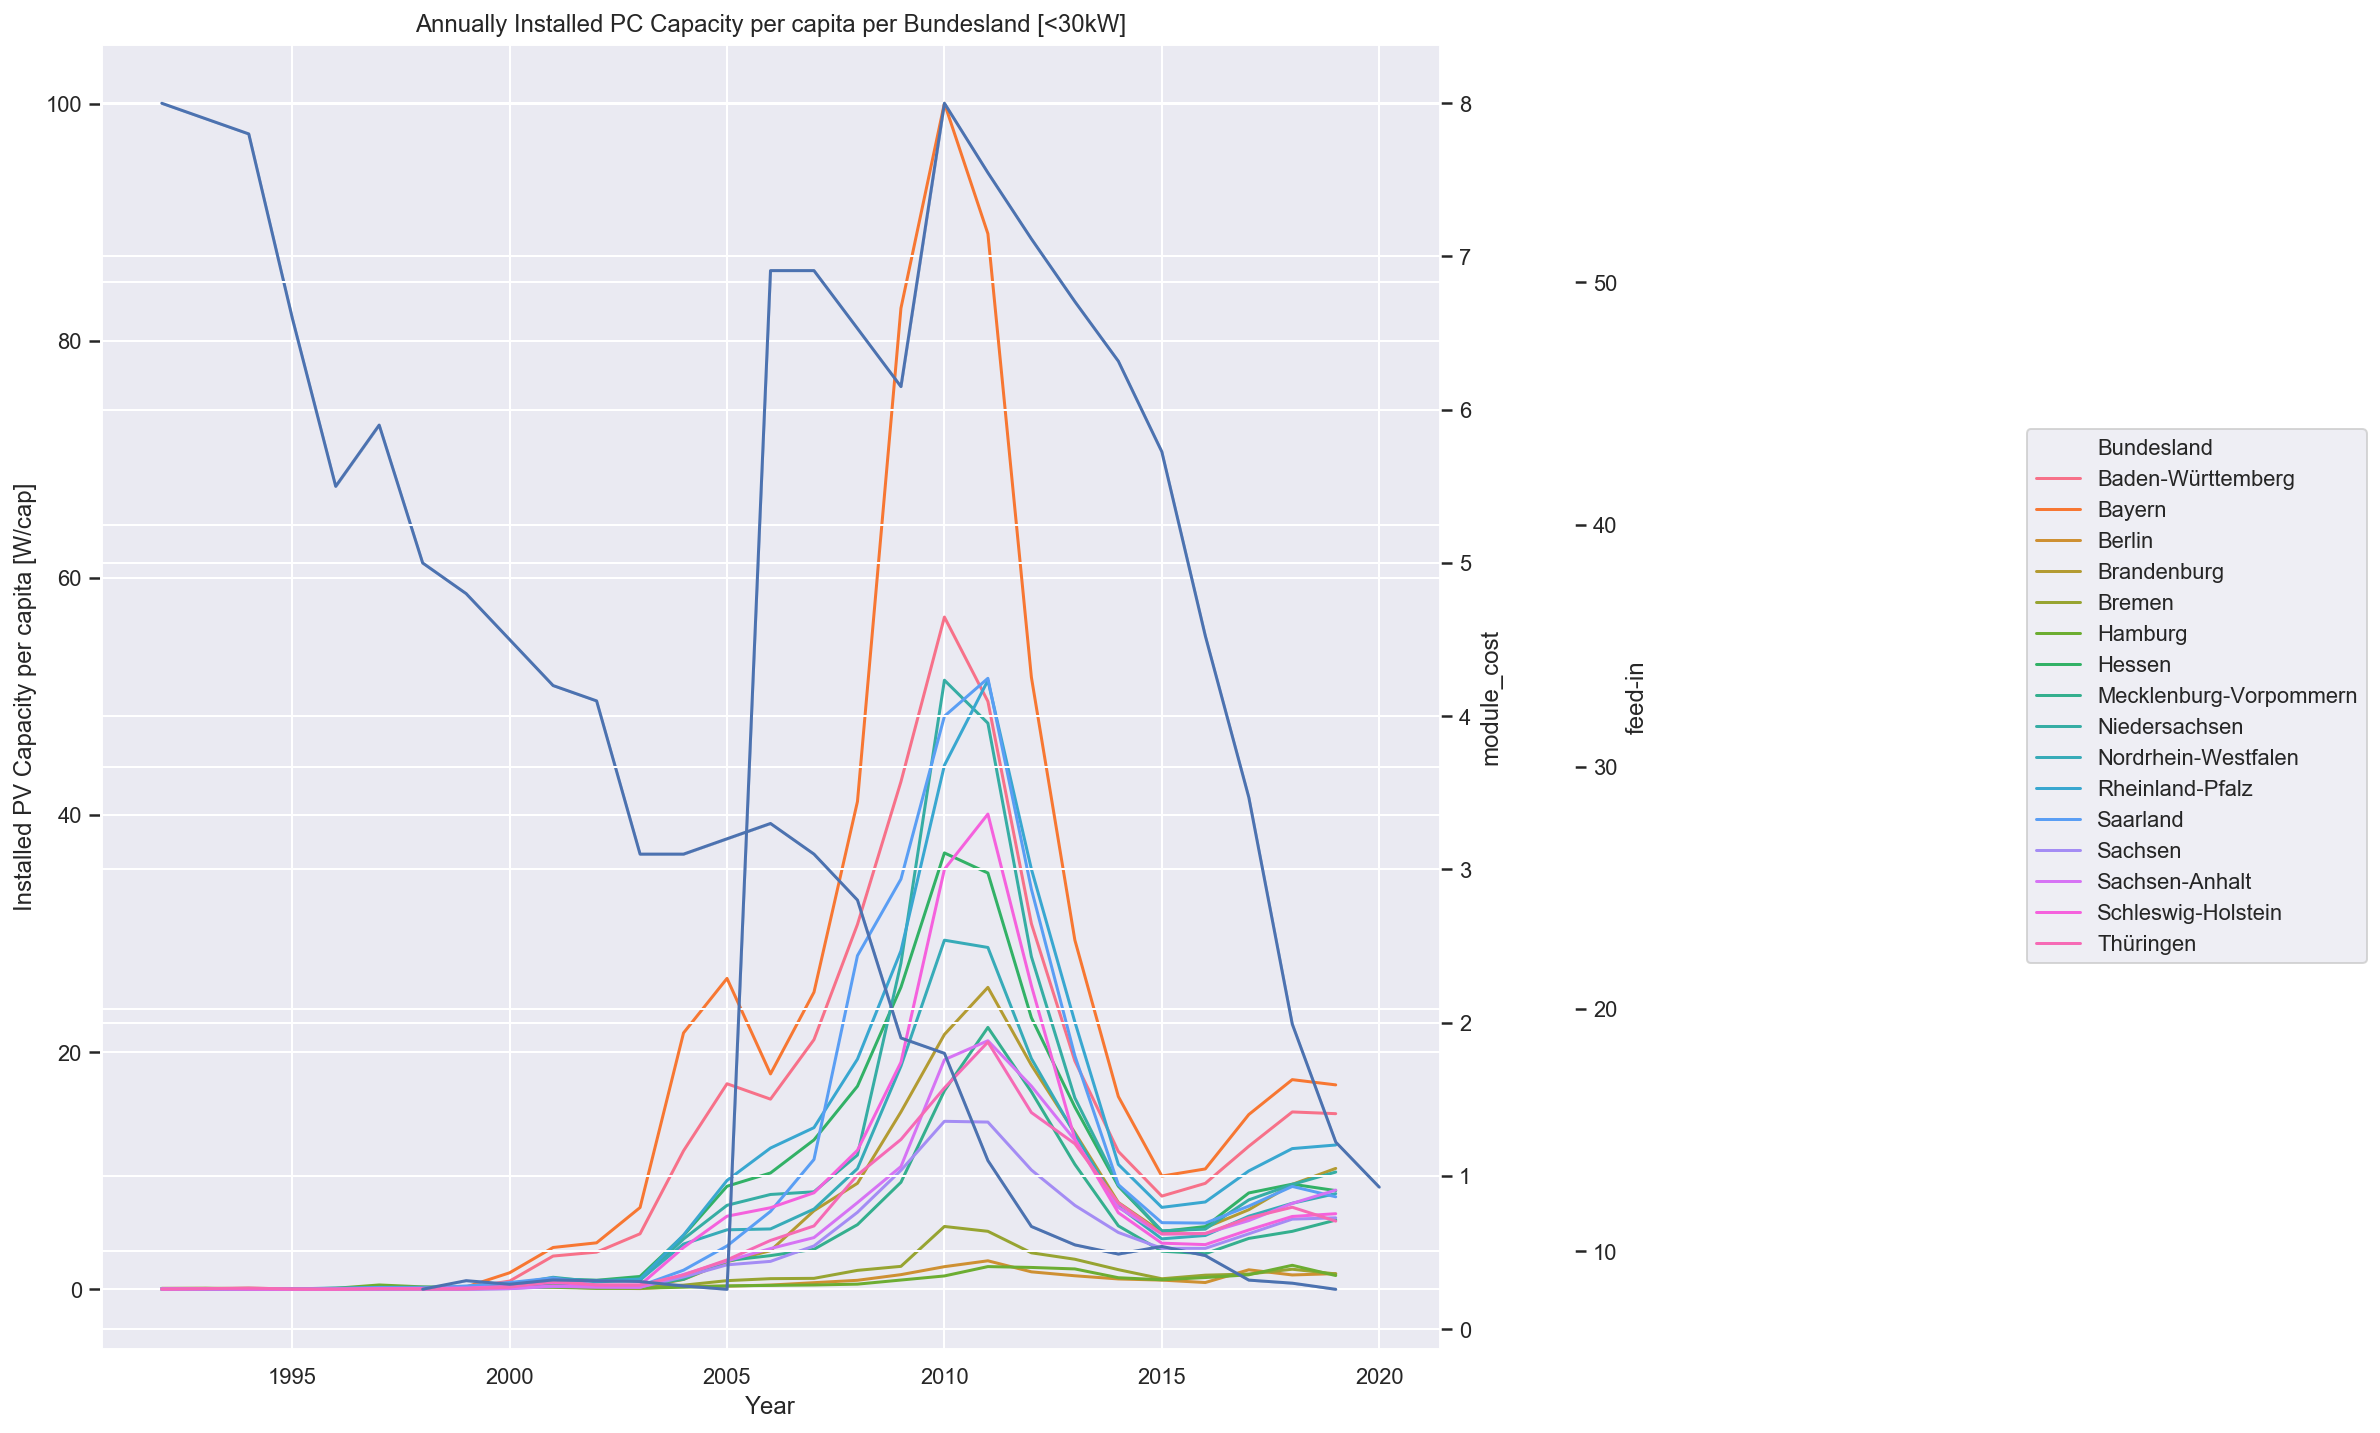

In [751]:
p1 = sns.lineplot(x = "Year", y="Installed_Cap_below_30_pc", hue="Bundesland", data = data_shifted)

#plot module-costs
ax2 = p1.twinx()
sns.lineplot(x = "Year", y="module_cost", color="black", dashes=True, data = data_shifted, ax = ax2)
ax2.spines['right'].set_position(('axes', 1.0))
ax2.lines[0].set_linestyle("--")

#plot feed-in
ax3 = p1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
sns.lineplot(x = "Year", y="feed-in", color="blue", data = data_shifted, ax = ax3)
ax3.lines[0].set_linestyle("--")

p1.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)
p1.set(xlabel="Year",
       ylabel="Installed PV Capacity per capita [W/cap]",
       title= "Annually Installed PC Capacity per capita per Bundesland [<30kW]")
plt.show()

In [796]:
mask_year = np.logical_or.reduce((X_full[:,0]<1998, #drop data before 1998
                                  X_full[:,0]>2019))
Y_full=Y_full[mask_year==False]
X_full=X_full[mask_year==False]
X_df=X_df[mask_year==False]
Bundesland_full=Bundesland_full[mask_year==False]

print(X_full.shape)
print(Y_full.shape)
print(Bundesland_full.shape)

(352, 9)
(352,)
(352,)


In [797]:
# splitting the data
split = 2008
mask = X_full[:,0] >= split # TRUE for test data from split-year on
X_train = X_full[mask == False]
Y_train = Y_full[mask == False]

X_test = X_full[mask == True]
Y_test = Y_full[mask == True]

Bundesland_train = Bundesland_full[mask==False]
Bundesland_test = Bundesland_full[mask==True]

print("mask", mask.shape)
print("train data", X_train.shape, Y_train.shape)
print("test data", X_test.shape,  Y_test.shape)
print("bundeslaender in train data", Bundesland_train.shape)
print("bundeslaender in test data", Bundesland_test.shape)

mask (352,)
train data (160, 9) (160,)
test data (192, 9) (192,)
bundeslaender in train data (160,)
bundeslaender in test data (192,)


### Polynomial Regression

In [798]:
from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=2)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, Y_train)

Y_train_pred = lin_reg.predict(X_train_poly)
Y_test_pred = lin_reg.predict(X_test_poly)

train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(Y_test,Y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(Y_train, Y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(Y_test, Y_test_pred), 2))

train RMS: 1.8474415358657432
test RMS: 21.500915045771535
train R2: 0.86
test R2: -0.86


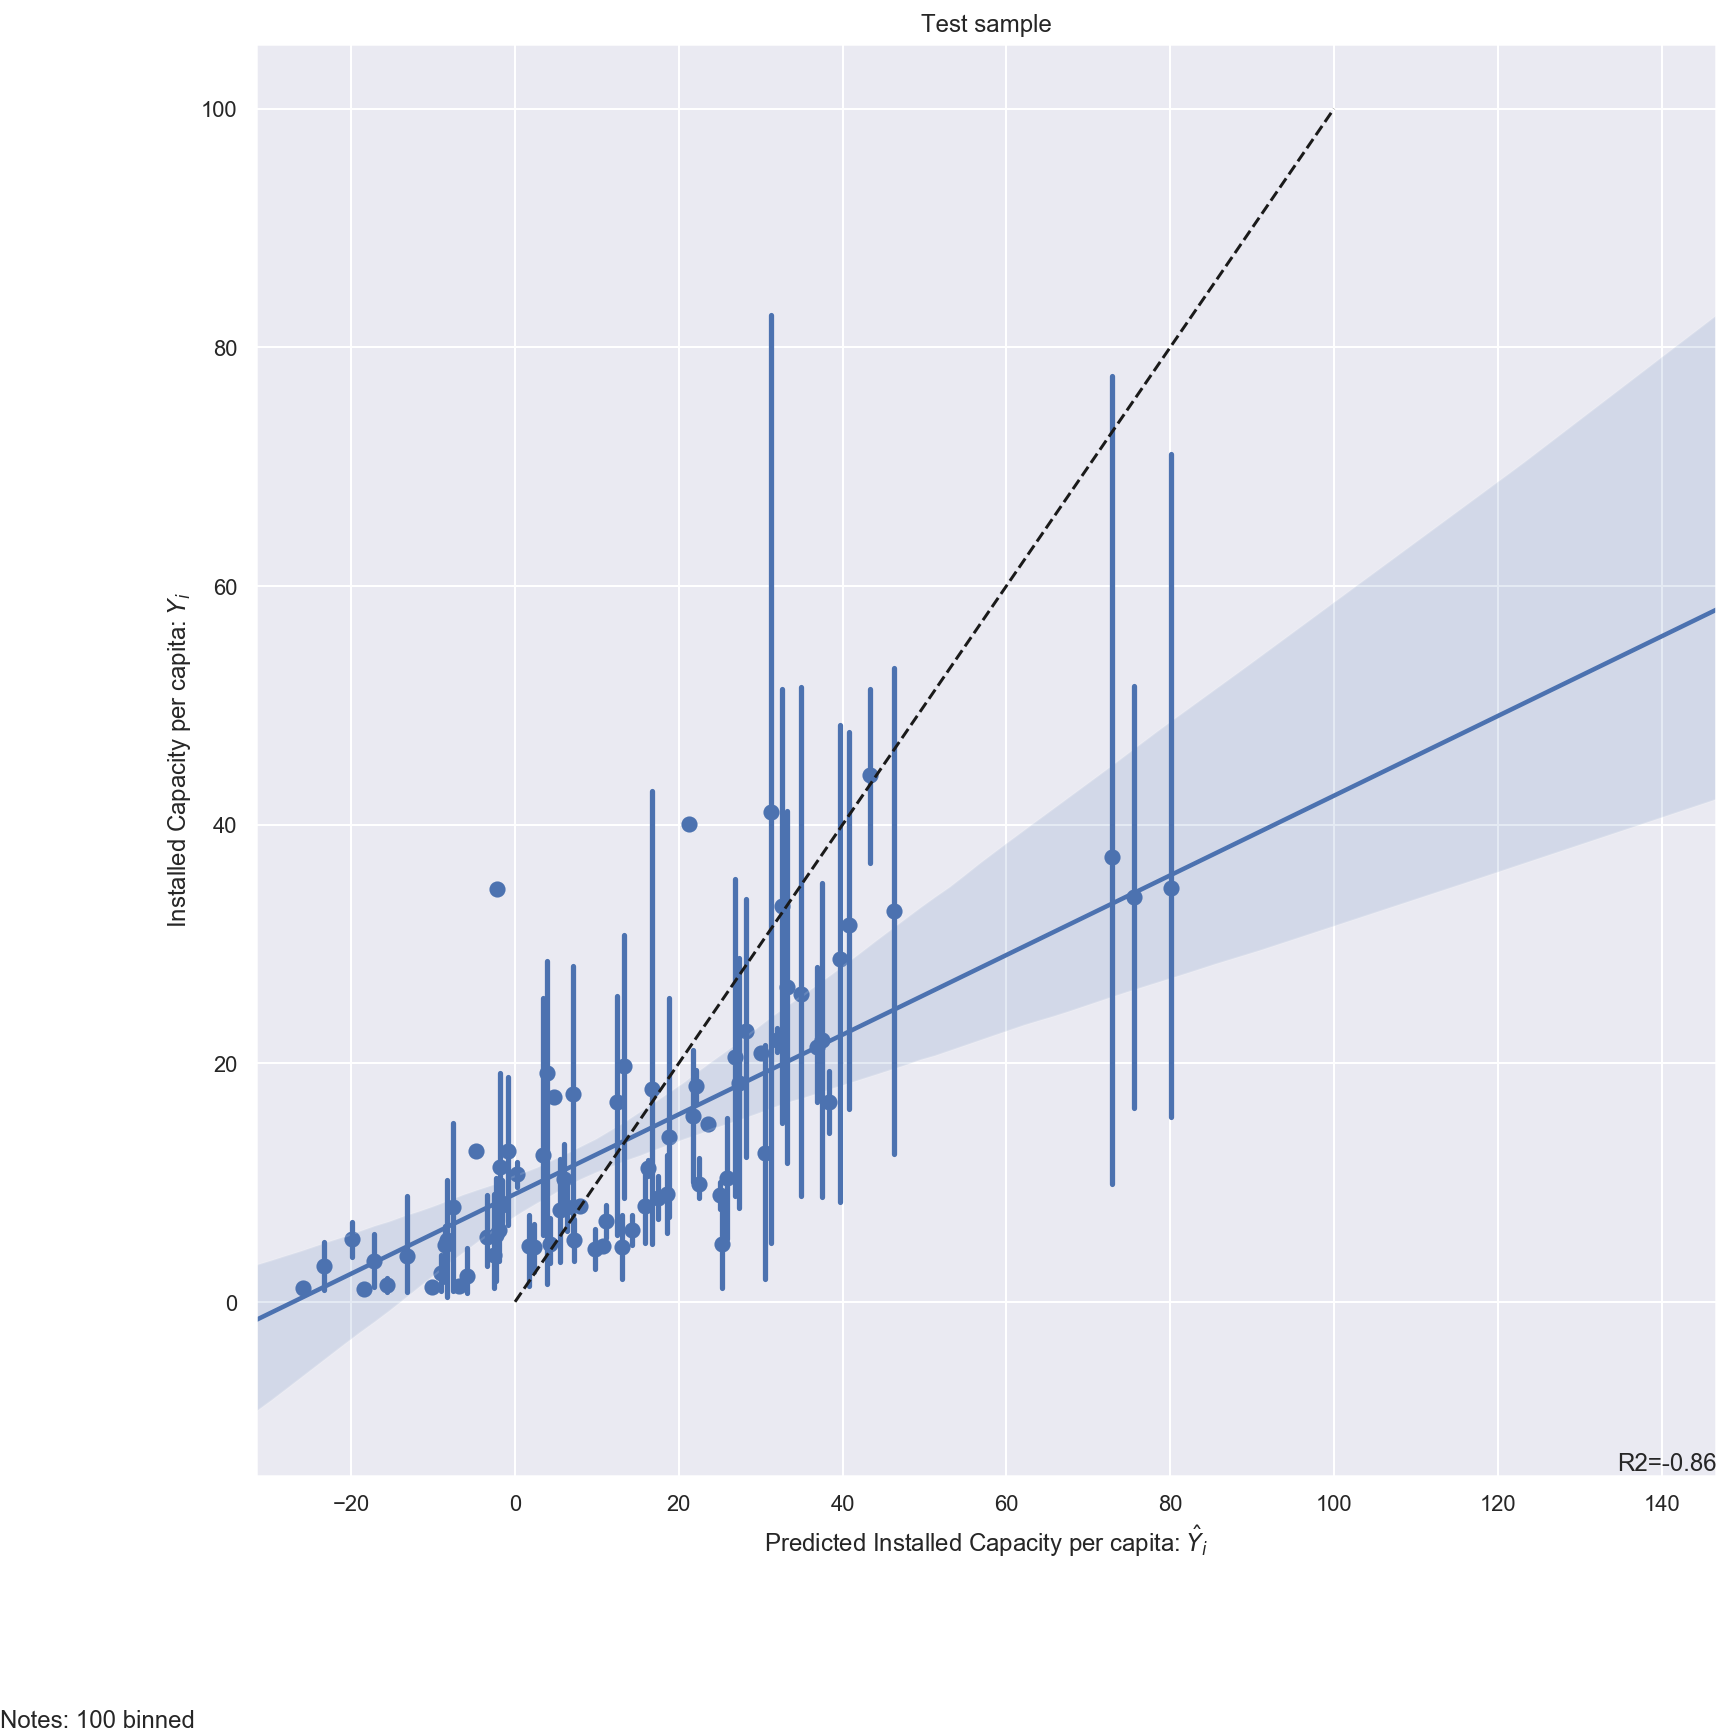

In [799]:
r2 = r2=round(r2_score(Y_test, Y_test_pred), 2)

# Regplot
g=sns.regplot(x= Y_test_pred, y=Y_test, x_bins = 80)
g=g.set_title("Test sample")
plt.xlabel("Predicted Installed Capacity per capita: $\hat{Y}_i$")
plt.ylabel("Installed Capacity per capita: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([0, 100], [0, 100], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

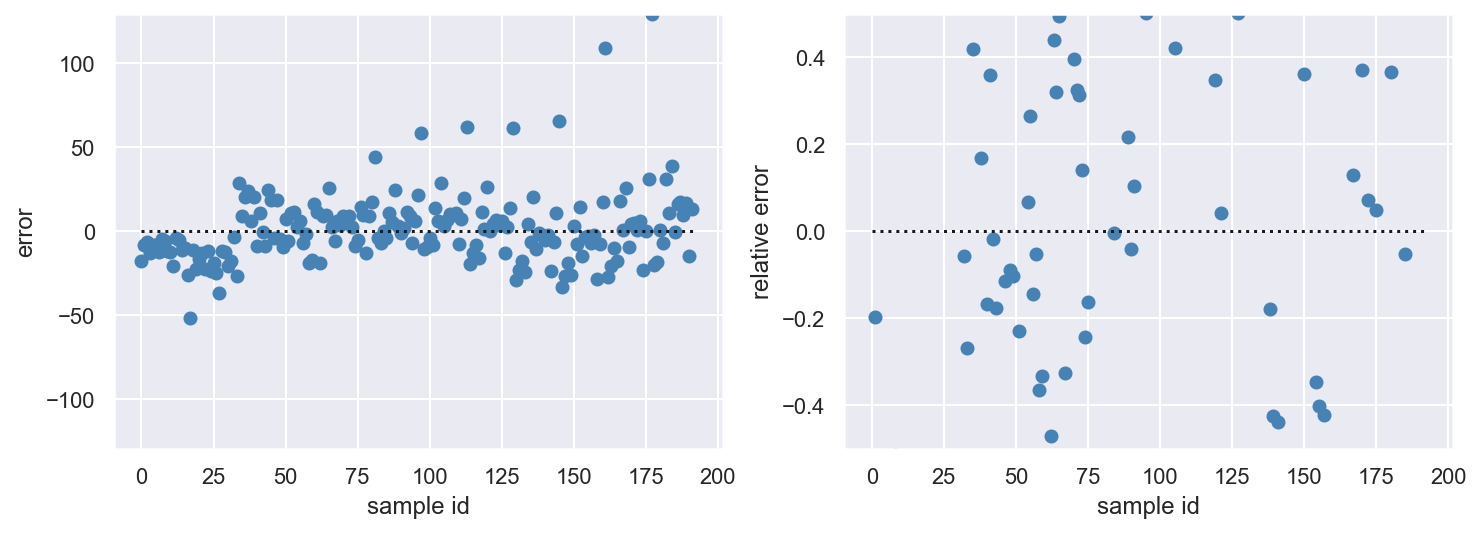

In [800]:
plot_fit_quality(Y_test, Y_test_pred)

[Text(0, 0.5, 'Installed Capacity per capita [W/cap]'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Annually Installed PV Capacity per capita in Germany [<30kW]')]

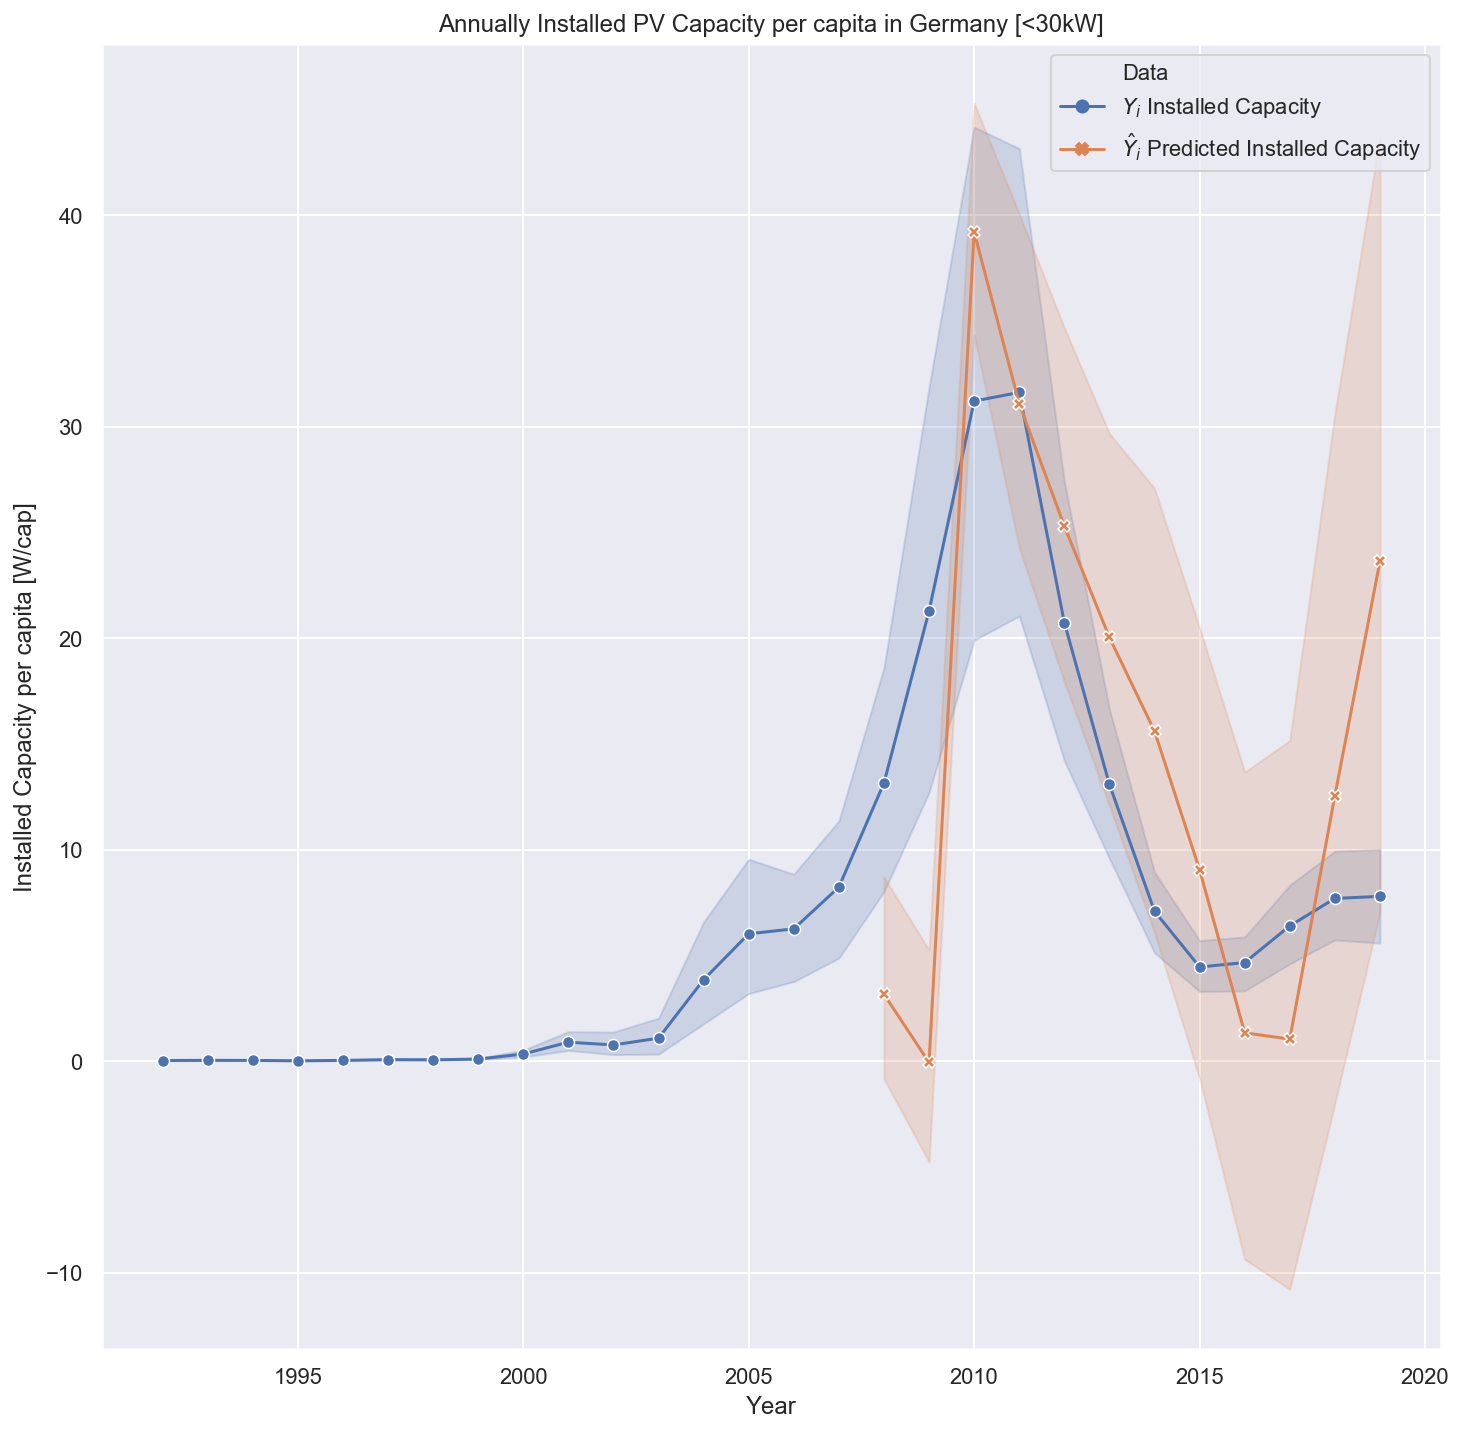

In [801]:
# extract the predicted data into a dataframe
df_pred = np.column_stack((Bundesland_test,X_test[:,0],Y_test,Y_test_pred))
df_pred = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test','Y_test_pred'])

# adjust data types
df_pred['Year'] = df_pred['Year'].astype(int)
df_pred['Y_test'] = df_pred['Y_test'].astype(float)
df_pred['Y_test_pred'] = df_pred['Y_test_pred'].astype(float)

# create a new dataframe for plotting the results
df_pred_plot = pd.DataFrame(df_pred, columns=['Bundesland','Year','Y_test_pred'])

# create a new variable "Data" to classify the type of data
df_pred_plot['Data'] = "$\hat{Y}_i$ Predicted Installed Capacity"
df_pred_plot = df_pred_plot.rename(columns = {'Y_test_pred':'Y'})

# merge two data frames with actual and predicted data together
df_plot = pd.merge(Y, df_pred_plot , how='outer', on=['Year','Bundesland','Y','Data'])
df_plot = df_plot.sort_values(by=['Year','Bundesland'])

# plot the results
ax = sns.lineplot(x="Year", y="Y", hue="Data", style="Data", markers=True, dashes=False,
                  data=df_plot)
ax.set(xlabel="Year",
       ylabel="Installed Capacity per capita [W/cap]",
       title= "Annually Installed PV Capacity per capita in Germany [<30kW]")

In [805]:
# apply different masks
mask_year = np.logical_or.reduce((X_full[:,0]<1998, #drop data before 1998
                                  X_full[:,0]>2015))
Y_full=Y_full[mask_year==False]
X_full=X_full[mask_year==False]
X_df=X_df[mask_year==False]
Bundesland_full=Bundesland_full[mask_year==False]

print(X_full.shape)
print(Y_full.shape)
print(Bundesland_full.shape)

(288, 9)
(288,)
(288,)


In [806]:
# splitting the data
split = 2008
mask = X_full[:,0] >= split # TRUE for test data from split-year on
X_train = X_full[mask == False]
Y_train = Y_full[mask == False]

X_test = X_full[mask == True]
Y_test = Y_full[mask == True]

Bundesland_train = Bundesland_full[mask==False]
Bundesland_test = Bundesland_full[mask==True]

print("mask", mask.shape)
print("train data", X_train.shape, Y_train.shape)
print("test data", X_test.shape,  Y_test.shape)
print("bundeslaender in train data", Bundesland_train.shape)
print("bundeslaender in test data", Bundesland_test.shape)

mask (288,)
train data (160, 9) (160,)
test data (128, 9) (128,)
bundeslaender in train data (160,)
bundeslaender in test data (128,)


In [807]:
from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=2)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, Y_train)

Y_train_pred = lin_reg.predict(X_train_poly)
Y_test_pred = lin_reg.predict(X_test_poly)

train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(Y_test,Y_test_pred)
test_rmse = np.sqrt(test_mse)

print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(Y_train, Y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(Y_test, Y_test_pred), 2))

train RMS: 1.8474415358657432
test RMS: 16.4432012505808
train R2: 0.86
test R2: 0.16
